# 🧹 Tratamento de Dados de Combustíveis - 2011

Este notebook tem como objetivo realizar o tratamento inicial dos dados de preços de combustíveis da ANP para o ano de 2011. Aqui, vamos garantir que os dados estejam limpos e estruturados para análises futuras.

## Objetivos:
- Carregar os dados dos dois semestres de 2011
- Verificar a consistência das colunas
- Identificar e tratar valores ausentes
- Preparar os dados para análises posteriores

In [1]:
import pandas as pd
import os

# Caminhos dos arquivos
caminho_1s = 'dados_anp_ca/ca-2011-01.csv'
caminho_2s = 'dados_anp_ca/ca-2011-02.csv'

def exibir_colunas(df, nome):
    print(f"\n📋 Colunas do {nome}:")
    print("-" * 50)
    for i, col in enumerate(df.columns, 1):
        tipo = str(df[col].dtype)
        print(f"{i:2d}. {col:<40} ({tipo})")
    print(f"\nTotal: {len(df.columns)} colunas")

# Lendo os arquivos CSV
try:
    # Lendo o primeiro semestre
    print("📂 Carregando dados do primeiro semestre...")
    df_1s = pd.read_csv(caminho_1s, encoding='utf-8', sep=';', decimal=',')
    print(f"✅ Registros carregados: {len(df_1s):,}")
    exibir_colunas(df_1s, "Primeiro Semestre")
    
    # Lendo o segundo semestre
    print("\n📂 Carregando dados do segundo semestre...")
    df_2s = pd.read_csv(caminho_2s, encoding='utf-8', sep=';', decimal=',')
    print(f"✅ Registros carregados: {len(df_2s):,}")
    exibir_colunas(df_2s, "Segundo Semestre")
    
    # Verificação de colunas iguais
    colunas_1s = set(df_1s.columns)
    colunas_2s = set(df_2s.columns)
    
    if colunas_1s == colunas_2s:
        print("\n✅ Todas as colunas são iguais entre os dois semestres.")
    else:
        print("\n❌ As colunas são diferentes entre os semestres.")
        
        # Mostrar diferenças
        apenas_1s = colunas_1s - colunas_2s
        apenas_2s = colunas_2s - colunas_1s
        
        if apenas_1s:
            print(f"\n🔍 Colunas apenas no 1º semestre ({len(apenas_1s)}):")
            for col in sorted(apenas_1s):
                print(f"   - {col}")
                
        if apenas_2s:
            print(f"\n🔍 Colunas apenas no 2º semestre ({len(apenas_2s)}):")
            for col in sorted(apenas_2s):
                print(f"   - {col}")
    
    # Armazenando os DataFrames
    dados_2011 = {
        'primeiro_semestre': df_1s,
        'segundo_semestre': df_2s
    }
    
except UnicodeDecodeError:
    print("\n❌ Erro de codificação: O arquivo não está em UTF-8. Tentando com ISO-8859-1...")
    try:
        # Tentar novamente com ISO-8859-1 se UTF-8 falhar
        df_1s = pd.read_csv(caminho_1s, encoding='ISO-8859-1', sep=';', decimal=',')
        df_2s = pd.read_csv(caminho_2s, encoding='ISO-8859-1', sep=';', decimal=',')
        print("✅ Arquivos carregados com sucesso usando ISO-8859-1")
        
        # Exibir informações novamente
        exibir_colunas(df_1s, "Primeiro Semestre (ISO-8859-1)")
        exibir_colunas(df_2s, "Segundo Semestre (ISO-8859-1)")
        
        # Armazenar os DataFrames
        dados_2011 = {
            'primeiro_semestre': df_1s,
            'segundo_semestre': df_2s
        }
        
    except Exception as e:
        print(f"\n❌ Erro ao carregar os arquivos: {str(e)}")
        
except Exception as e:
    print(f"\n❌ Erro ao processar os arquivos: {str(e)}")

📂 Carregando dados do primeiro semestre...
✅ Registros carregados: 649,693

📋 Colunas do Primeiro Semestre:
--------------------------------------------------
 1. Regiao - Sigla                           (object)
 2. Estado - Sigla                           (object)
 3. Municipio                                (object)
 4. Revenda                                  (object)
 5. CNPJ da Revenda                          (object)
 6. Nome da Rua                              (object)
 7. Numero Rua                               (object)
 8. Complemento                              (object)
 9. Bairro                                   (object)
10. Cep                                      (object)
11. Produto                                  (object)
12. Data da Coleta                           (object)
13. Valor de Venda                           (float64)
14. Valor de Compra                          (float64)
15. Unidade de Medida                        (object)
16. Bandeira                 

In [2]:
def analisar_colunas(df, nome_periodo):
    print(f"\n🔍 Análise de Colunas - {nome_periodo}")
    print("="*70)
    
    # Criar DataFrame com métricas de cada coluna
    analise = pd.DataFrame({
        'Tipo': df.dtypes,
        'Valores_Únicos': df.nunique(),
        'Valores_Nulos': df.isnull().sum(),
        '%_Nulos': (df.isnull().sum() / len(df) * 100).round(2)
    })
    
    # Classificar colunas
    def classificar_coluna(linha):
        # Colunas com alta cardinalidade ou muitos nulos são menos úteis
        if linha['%_Nulos'] > 50:
            return '❌ Baixa Utilidade'
        elif linha['Valores_Únicos'] == len(df):
            return '⚠️ Identificador Único (CNPJ, ID, etc)'
        elif linha['Tipo'] == 'object':
            if linha['Valores_Únicos'] < 50:
                return '✅ Categórica'
            else:
                return '📝 Texto Livre'
        elif 'data' in linha.name.lower():
            return '📅 Data (converter para datetime)'
        elif 'valor' in linha.name.lower() or 'preço' in linha.name.lower():
            return '💰 Métrica Numérica (importante)'
        else:
            return '🔢 Numérica'
    
    analise['Classificação'] = analise.apply(classificar_coluna, axis=1)
    
    # Ordenar por classificação e nome
    analise = analise.sort_values(['Classificação', 'Valores_Únicos'])
    
    # Exibir resultados
    with pd.option_context('display.max_rows', None, 'display.width', 1000):
        display(analise)
    
    return analise

# Analisar colunas de cada período
print("🔍 INICIANDO ANÁLISE DAS COLUNAS")
analise_1s = analisar_colunas(df_1s, "Primeiro Semestre")
analise_2s = analisar_colunas(df_2s, "Segundo Semestre")

# Identificar diferenças entre os períodos
colunas_diferentes = set(df_1s.columns).symmetric_difference(df_2s.columns)
if colunas_diferentes:
    print("\n⚠️  ATENÇÃO: Diferenças nas colunas entre os semestres:", 
          ', '.join(colunas_diferentes))

🔍 INICIANDO ANÁLISE DAS COLUNAS

🔍 Análise de Colunas - Primeiro Semestre


,Tipo,Valores_Únicos,Valores_Nulos,%_Nulos,Classificação
Unidade de Medida,object,2,0,0.00,✅ Categórica
Produto,object,4,0,0.00,✅ Categórica
Regiao - Sigla,object,5,0,0.00,✅ Categórica
Estado - Sigla,object,27,0,0.00,✅ Categórica
Complemento,object,2372,476570,73.35,❌ Baixa Utilidade
Valor de Compra,float64,14951,369563,56.88,❌ Baixa Utilidade
Valor de Venda,float64,1614,0,0.00,💰 Métrica Numérica (importante)
Bandeira,object,72,0,0.00,📝 Texto Livre
Data da Coleta,object,104,0,0.00,📝 Texto Livre
Municipio,object,602,0,0.00,📝 Texto Livre



🔍 Análise de Colunas - Segundo Semestre


,Tipo,Valores_Únicos,Valores_Nulos,%_Nulos,Classificação
Unidade de Medida,object,2,0,0.00,✅ Categórica
Produto,object,4,0,0.00,✅ Categórica
Regiao - Sigla,object,5,0,0.00,✅ Categórica
Estado - Sigla,object,27,0,0.00,✅ Categórica
Complemento,object,2447,477665,73.49,❌ Baixa Utilidade
Valor de Compra,float64,12562,378444,58.22,❌ Baixa Utilidade
Valor de Venda,float64,1382,0,0.00,💰 Métrica Numérica (importante)
Bandeira,object,93,0,0.00,📝 Texto Livre
Data da Coleta,object,108,0,0.00,📝 Texto Livre
Municipio,object,605,0,0.00,📝 Texto Livre


# 🔍 Seleção Estratégica de Colunas para Análise

## 📊 Colunas Selecionadas e Sua Relevância

### 📍 Dados Geográficos
- **Região**: Permite análises macro por região do país
- **Estado**: Essencial para análises estaduais e comparações regionais
- **Município**: Para análises detalhadas em nível municipal
- **Bandeira**: Importante para análise de mercado e comparação entre postos

### 🏷️ Dados de Identificação
- **Revenda**: Identifica o estabelecimento vendedor
- **CNPJ da Revenda**: Identificador único para análise por estabelecimento
- **Produto**: Tipo de combustível (gasolina, diesel, etanol, etc)

### 📅 Dados Temporais
- **Data da Coleta**: Fundamental para análise de séries temporais, tendências e sazonalidade

### 💰 Dados Financeiros
- **Valor de Venda**: Preço final ao consumidor
- **Valor de Compra**: Custo para a revenda
- **Unidade de Medida**: Garante que as comparações sejam feitas corretamente

### 🗑️ Colunas Removidas
As demais colunas foram removidas por:
- Conterem informações redundantes
- Não serem relevantes para as análises propostas
- Estarem vazias ou com baixa taxa de preenchimento
- Não adicionarem valor analítico significativo

## 🎯 Objetivo
Esta seleção visa otimizar o conjunto de dados para análises de preços de combustíveis, mantendo apenas as informações mais relevantes para:
- Análises de preços por região/estado/município
- Comparação entre bandeiras de postos
- Análises temporais de variação de preços
- Cálculo de margens de lucro (diferença entre venda e compra)

In [3]:
# Dicionário de padronização dos nomes das colunas
padrao_colunas = {
    'Regiao - Sigla': 'regiao_sigla',
    'Estado - Sigla': 'estado_sigla',
    'Municipio': 'municipio',
    'Revenda': 'revenda',
    'CNPJ da Revenda': 'cnpj_revenda',
    'Produto': 'produto',
    'Data da Coleta': 'data_coleta',
    'Valor de Venda': 'valor_venda',
    'Valor de Compra': 'valor_compra',
    'Unidade de Medida': 'unidade_medida',
    'Bandeira': 'bandeira'
}

# Lista das colunas que serão mantidas (usando os nomes originais)
colunas_essenciais = [
    'Regiao - Sigla',
    'Estado - Sigla',
    'Municipio',
    'Revenda',
    'CNPJ da Revenda',
    'Produto',
    'Data da Coleta',
    'Valor de Venda',
    'Valor de Compra',
    'Unidade de Medida',
    'Bandeira'
]

# Filtrar e renomear as colunas
def preparar_dataframe(df):
    # Filtrar colunas
    df = df[colunas_essenciais].copy()
    # Renomear colunas
    return df.rename(columns=padrao_colunas)

# Aplicar a ambos os dataframes
df_1s = preparar_dataframe(df_1s)
df_2s = preparar_dataframe(df_2s)

# Verificar o resultado
print("🔍 Colunas após a filtragem e padronização:")
print("-" * 50)
print(df_1s.columns.tolist())

# Mostrar as primeiras linhas do primeiro semestre como exemplo
print("\n📋 Dados do Primeiro Semestre (amostra):")
display(df_1s.head(2))

# Mostrar as primeiras linhas do segundo semestre como exemplo
print("\n📋 Dados do Segundo Semestre (amostra):")
display(df_2s.head(2))

# Converter a coluna de data
df_1s['data_coleta'] = pd.to_datetime(df_1s['data_coleta'], dayfirst=True)
df_2s['data_coleta'] = pd.to_datetime(df_2s['data_coleta'], dayfirst=True)

print("\n✅ Dados preparados com sucesso!")
print(f"Primeiro semestre: {len(df_1s)} registros")
print(f"Segundo semestre: {len(df_2s)} registros")

🔍 Colunas após a filtragem e padronização:
--------------------------------------------------
['regiao_sigla', 'estado_sigla', 'municipio', 'revenda', 'cnpj_revenda', 'produto', 'data_coleta', 'valor_venda', 'valor_compra', 'unidade_medida', 'bandeira']

📋 Dados do Primeiro Semestre (amostra):


,regiao_sigla,estado_sigla,municipio,revenda,cnpj_revenda,produto,data_coleta,valor_venda,valor_compra,unidade_medida,bandeira
0,SE,SP,ARARAQUARA,RAIZEN ARARAQUARA ACUCAR E ALCOOL LTDA,43.960.335/0001-64,GASOLINA,04/01/2011,2.54,NaN,R$ / litro,BRANCA
1,SE,SP,ARARAQUARA,RAIZEN ARARAQUARA ACUCAR E ALCOOL LTDA,43.960.335/0001-64,ETANOL,04/01/2011,1.73,NaN,R$ / litro,BRANCA



📋 Dados do Segundo Semestre (amostra):


,regiao_sigla,estado_sigla,municipio,revenda,cnpj_revenda,produto,data_coleta,valor_venda,valor_compra,unidade_medida,bandeira
0,S,RS,CANOAS,METROPOLITANO COMERCIO DE COMBUSTIVEIS LTDA,88.587.589/0001-17,GASOLINA,04/07/2011,2.71,NaN,R$ / litro,BRANCA
1,S,RS,CANOAS,METROPOLITANO COMERCIO DE COMBUSTIVEIS LTDA,88.587.589/0001-17,ETANOL,04/07/2011,2.09,NaN,R$ / litro,BRANCA



✅ Dados preparados com sucesso!
Primeiro semestre: 649693 registros
Segundo semestre: 650008 registros


# 🔍 Análise de Valores Nulos

## 📊 Visão Geral dos Dados Ausentes

Vamos analisar a quantidade e porcentagem de valores nulos em cada coluna do nosso conjunto de dados. Esta análise é crucial para entendermos a qualidade dos dados e decidirmos as melhores estratégias de tratamento.

### Por que essa análise é importante?
1. **Qualidade dos Dados**: Identificar colunas com muitos valores ausentes que podem comprometer as análises.
2. **Tomada de Decisão**: Decidir se devemos preencher, remover ou manter os valores nulos.
3. **Impacto nas Análises**: Entender como os valores ausentes podem afetar os resultados das nossas análises.

### Próximos Passos:
1. Verificar a quantidade de valores nulos por coluna
2. Calcular a porcentagem de valores nulos em relação ao total de registros
3. Identificar padrões nos dados ausentes
4. Decidir a melhor estratégia de tratamento para cada caso

Vamos começar executando a análise de valores nulos para cada semestre separadamente.

In [4]:
# Função para análise de valores nulos
def analisar_nulos(df, nome_periodo):
    print(f"\n🔍 Análise de Valores Nulos - {nome_periodo}")
    print("="*70)
    
    # Calcular totais
    total_registros = len(df)
    print(f"📊 Total de registros: {total_registros:,}")
    
    # Criar DataFrame com análise de nulos
    nulos = pd.DataFrame({
        'Valores_Nulos': df.isnull().sum(),
        'Percentual_Nulos': (df.isnull().sum() / total_registros * 100).round(2)
    }).sort_values('Valores_Nulos', ascending=False)
    
    # Exibir apenas colunas com valores nulos
    nulos = nulos[nulos['Valores_Nulos'] > 0]
    
    if len(nulos) == 0:
        print("✅ Nenhum valor nulo encontrado!")
    else:
        print(f"⚠️  Colunas com valores nulos: {len(nulos)} de {len(df.columns)} colunas")
        display(nulos)
    
    return nulos

# Executar análise para ambos os semestres
nulos_1s = analisar_nulos(df_1s, "Primeiro Semestre")
nulos_2s = analisar_nulos(df_2s, "Segundo Semestre")


🔍 Análise de Valores Nulos - Primeiro Semestre
📊 Total de registros: 649,693
⚠️  Colunas com valores nulos: 1 de 11 colunas


,Valores_Nulos,Percentual_Nulos
valor_compra,369563,56.88



🔍 Análise de Valores Nulos - Segundo Semestre
📊 Total de registros: 650,008
⚠️  Colunas com valores nulos: 1 de 11 colunas


,Valores_Nulos,Percentual_Nulos
valor_compra,378444,58.22


# 🧹 Tratamento de Valores Ausentes

## 📊 Estratégia de Preenchimento

### Para Valores Numéricos (ex: Valor de Compra):
- **Método**: Preenchimento com a mediana do grupo
- **Vantagens**:
  - Menos sensível a outliers que a média
  - Mantém a distribuição original dos dados
  - Considera o contexto (produto, bandeira, região)

### Para Valores Categóricos (ex: Bandeira, Município):
- **Método**: Preenchimento com categoria "Desconhecido"
- **Vantagens**:
  - Não inventa dados que não existem
  - Mantém a transparência do tratamento
  - Permite identificar registros que precisam de atenção especial

In [5]:
def imputar_valores_numericos(df, coluna, colunas_agrupar):
    """
    Imputa valores numéricos faltantes usando a mediana do grupo.
    
    Parâmetros:
    - df: DataFrame com os dados
    - coluna: Nome da coluna numérica a ser preenchida
    - colunas_agrupar: Lista de colunas para agrupar e calcular a mediana
    
    Retorna:
    - DataFrame com os valores faltantes preenchidos
    """
    # Criar cópia para evitar avisos
    df = df.copy()
    
    # Calcular a mediana por grupo
    medianas = df.groupby(colunas_agrupar)[coluna].transform('median')
    
    # Preencher valores nulos com a mediana do grupo
    df[coluna] = df[coluna].fillna(medianas)
    
    # Se ainda houver valores nulos (grupos sem amostras), preencher com a mediana global
    if df[coluna].isnull().any():
        mediana_global = df[coluna].median()
        df[coluna] = df[coluna].fillna(mediana_global)
        print(f"  - {df[coluna].isnull().sum()} valores nulos restantes em '{coluna}' preenchidos com mediana global")
    
    return df

def imputar_valores_categoricos(df, colunas):
    """
    Preenche valores categóricos faltantes com a moda (valor mais frequente) de cada coluna.
    
    Parâmetros:
    - df: DataFrame com os dados
    - colunas: Lista de colunas categóricas a serem preenchidas
    
    Retorna:
    - DataFrame com os valores faltantes preenchidos
    """
    df = df.copy()
    
    for col in colunas:
        if col in df.columns:
            # Encontrar o valor mais frequente (moda)
            moda = df[col].mode()[0]
            # Contar valores nulos antes
            nulos_antes = df[col].isnull().sum()
            # Preencher valores nulos
            df[col] = df[col].fillna(moda)
            # Contar valores nulos depois
            nulos_depois = df[col].isnull().sum()
            
            if nulos_antes > 0:
                print(f"  - {nulos_antes} valores nulos em '{col}' preenchidos com '{moda}'")
    return df

# Para o primeiro semestre
print("\n" + "="*60)
print("📊 TRATAMENTO - PRIMEIRO SEMESTRE".center(60))
print("="*60)

# Tratar valores numéricos
colunas_agrupar = ['produto', 'estado_sigla', 'municipio']
df_1s = imputar_valores_numericos(df_1s, 'valor_venda', colunas_agrupar)
df_1s = imputar_valores_numericos(df_1s, 'valor_compra', colunas_agrupar)

# Tratar valores categóricos
colunas_cat = ['bandeira', 'unidade_medida', 'regiao_sigla']
df_1s = imputar_valores_categoricos(df_1s, colunas_cat)

# Para o segundo semestre
print("\n" + "="*60)
print("📊 TRATAMENTO - SEGUNDO SEMESTRE".center(60))
print("="*60)

# Tratar valores numéricos
df_2s = imputar_valores_numericos(df_2s, 'valor_venda', colunas_agrupar)
df_2s = imputar_valores_numericos(df_2s, 'valor_compra', colunas_agrupar)

# Tratar valores categóricos
df_2s = imputar_valores_categoricos(df_2s, colunas_cat)

print("\n✅ Tratamento concluído para ambos os semestres!")
print(f"- Primeiro semestre: {len(df_1s)} registros")
print(f"- Segundo semestre: {len(df_2s)} registros")


              📊 TRATAMENTO - PRIMEIRO SEMESTRE              
  - 0 valores nulos restantes em 'valor_compra' preenchidos com mediana global

              📊 TRATAMENTO - SEGUNDO SEMESTRE               
  - 0 valores nulos restantes em 'valor_compra' preenchidos com mediana global

✅ Tratamento concluído para ambos os semestres!
- Primeiro semestre: 649693 registros
- Segundo semestre: 650008 registros


In [6]:
# Verificar se ainda existem valores nulos
print("\n" + "="*70)
print("VERIFICAÇÃO FINAL DE VALORES NULOS")
print("="*70)
print("\nPrimeiro Semestre:")
display(df_1s.isnull().sum())
print("\nSegundo Semestre:")
display(df_2s.isnull().sum())


VERIFICAÇÃO FINAL DE VALORES NULOS

Primeiro Semestre:


regiao_sigla      0
estado_sigla      0
municipio         0
revenda           0
cnpj_revenda      0
produto           0
data_coleta       0
valor_venda       0
valor_compra      0
unidade_medida    0
bandeira          0
dtype: int64


Segundo Semestre:


regiao_sigla      0
estado_sigla      0
municipio         0
revenda           0
cnpj_revenda      0
produto           0
data_coleta       0
valor_venda       0
valor_compra      0
unidade_medida    0
bandeira          0
dtype: int64

# 🔍 Análise de Inconsistências nos Preços

## 📌 Objetivo
Identificar e corrigir registros onde `Valor de Venda < Valor de Compra`, o que indica prejuízo financeiro.

## 💡 Por que analisar?
- **Erros de Dados**: Identificar registros com valores incorretos
- **Saúde Financeira**: Garantir margens positivas
- **Qualidade**: Manter a confiabilidade do dataset

## 📊 O que vamos verificar?
- Quantos registros estão com prejuízo
- Quais produtos/bandeiras têm mais problemas
- Qual o impacto financeiro dessas inconsistências

## 🔧 Próximos Passos
1. Identificar registros problemáticos
2. Analisar padrões
3. Corrigir os valores
4. Validar os resultados

In [7]:
def verificar_inconsistencias_precos(df, nome_periodo):
    """
    Verifica se existem valores de venda menores que os de compra,
    o que seria uma inconsistência nos dados.
    
    Parâmetros:
    - df: DataFrame com os dados
    - nome_periodo: Nome do período para exibição
    
    Retorna:
    - DataFrame com as inconsistências encontradas ou None se não houver
    """
    print(f"\n🔍 Verificando Inconsistências de Preços - {nome_periodo}")
    print("="*70)
    
    # Verificar se existem valores de venda menores que compra
    inconsistencias = df[df['valor_venda'] < df['valor_compra']].copy()
    total_inconsistencias = len(inconsistencias)
    total_linhas = len(df)
    percentual = (total_inconsistencias / total_linhas) * 100 if total_linhas > 0 else 0
    
    # Resumo Executivo
    print("\n" + "="*70)
    print("📊 RESUMO DAS INCONSISTÊNCIAS")
    print("="*70)
    print(f"✅ Total de registros analisados: {total_linhas:,}")
    print(f"❌ Registros com VENDA < COMPRA: {total_inconsistencias:,} ({percentual:.2f}%)")
    print("="*70)
    
    if total_inconsistencias > 0:
        # Calcular a diferença
        inconsistencias['diferenca'] = inconsistencias['valor_compra'] - inconsistencias['valor_venda']
        impacto_total = inconsistencias['diferenca'].sum()
        
        print("\n📋 DETALHES DAS INCONSISTÊNCIAS:")
        print(f"  - Diferença Média: R$ {inconsistencias['diferenca'].mean():.2f}")
        print(f"  - Maior Diferença: R$ {inconsistencias['diferenca'].max():.2f}")
        print(f"  - Menor Diferença: R$ {inconsistencias['diferenca'].min():.2f}")
        print(f"  - Impacto Total:  R$ {impacto_total:,.2f}")
        
        print("\n📊 AMOSTRA DAS INCONSISTÊNCIAS (Top 5):")
        display(inconsistencias[['produto', 'bandeira', 'valor_compra', 
                              'valor_venda', 'diferenca']]
               .sort_values('diferenca', ascending=False).head())
        
        # Análise por produto
        print("\n📈 ANÁLISE POR PRODUTO:")
        analise_produto = inconsistencias.groupby('produto').agg(
            qtd_inconsistencias=('produto', 'size'),
            media_diferenca=('diferenca', 'mean'),
            impacto_total=('diferenca', 'sum')
        ).sort_values('qtd_inconsistencias', ascending=False)
        display(analise_produto)
        
        return inconsistencias
    else:
        print("\n✅ Nenhuma inconsistência encontrada!")
        return None

# Executar verificação para ambos os semestres
print("="*70)
print("ANÁLISE DE INCONSISTÊNCIAS NOS PREÇOS (venda < compra)")
print("="*70)

# Verificar primeiro semestre
inconsistencias_1s = verificar_inconsistencias_precos(df_1s, "Primeiro Semestre")

# Verificar segundo semestre
inconsistencias_2s = verificar_inconsistencias_precos(df_2s, "Segundo Semestre")

ANÁLISE DE INCONSISTÊNCIAS NOS PREÇOS (venda < compra)

🔍 Verificando Inconsistências de Preços - Primeiro Semestre

📊 RESUMO DAS INCONSISTÊNCIAS
✅ Total de registros analisados: 649,693
❌ Registros com VENDA < COMPRA: 9,995 (1.54%)

📋 DETALHES DAS INCONSISTÊNCIAS:
  - Diferença Média: R$ 0.12
  - Maior Diferença: R$ 0.76
  - Menor Diferença: R$ 0.00
  - Impacto Total:  R$ 1,197.15

📊 AMOSTRA DAS INCONSISTÊNCIAS (Top 5):


,produto,bandeira,valor_compra,valor_venda,diferenca
405163,DIESEL,PETROBRAS DISTRIBUIDORA S.A.,1.7800,1.020,0.7600
435357,ETANOL,RAIZEN,2.9357,2.199,0.7367
611475,ETANOL,BRANCA,2.3905,1.699,0.6915
120979,GNV,BRANCA,1.8690,1.190,0.6790
261634,GNV,ALESAT,1.8690,1.197,0.6720



📈 ANÁLISE POR PRODUTO:


,qtd_inconsistencias,media_diferenca,impacto_total
produto,,,
ETANOL,8304,0.107436,892.14930
GNV,1196,0.243501,291.22680
DIESEL,300,0.024465,7.33965
GASOLINA,195,0.032976,6.43025



🔍 Verificando Inconsistências de Preços - Segundo Semestre

📊 RESUMO DAS INCONSISTÊNCIAS
✅ Total de registros analisados: 650,008
❌ Registros com VENDA < COMPRA: 6,617 (1.02%)

📋 DETALHES DAS INCONSISTÊNCIAS:
  - Diferença Média: R$ 0.08
  - Maior Diferença: R$ 0.63
  - Menor Diferença: R$ 0.00
  - Impacto Total:  R$ 550.24

📊 AMOSTRA DAS INCONSISTÊNCIAS (Top 5):


,produto,bandeira,valor_compra,valor_venda,diferenca
511258,GNV,RUFF C.J.,1.90735,1.280,0.62735
536220,GNV,RUFF C.J.,1.90735,1.280,0.62735
239708,GNV,COSAN LUBRIFICANTES,1.90735,1.299,0.60835
287878,GNV,BRANCA,1.90735,1.299,0.60835
337993,GNV,BRANCA,1.90735,1.299,0.60835



📈 ANÁLISE POR PRODUTO:


,qtd_inconsistencias,media_diferenca,impacto_total
produto,,,
ETANOL,2775,0.052136,144.67665
GNV,2063,0.170378,351.49015
DIESEL,1716,0.029805,51.14495
GASOLINA,63,0.046438,2.92560


# 🔄 Correção de Inconsistências de Preços

## 📊 Estratégia de Correção

### Para Vendas com Prejuízo (Venda < Compra):
- **Método**: Ajuste com margem de segurança
- **Fórmula**:  
  `Novo Valor de Venda = Valor de Compra × (1 + margem_seguranca)`

- **Vantagens**:
  - Elimina prejuízos nas vendas
  - Mantém margem de lucro mínima configurável
  - Aplica correção apenas onde necessário

### Para Vendas Válidas (Venda ≥ Compra):
- **Método**: Mantém os valores originais
- **Vantagens**:
  - Preserva os dados corretos
  - Não altera registros que já estão consistentes
  - Mantém a integridade das informações

## ⚙️ Configuração Padrão
- **Margem de Segurança**: 10% (0.10)
- **Personalização**: Ajustável conforme necessidade
- **Não-destrutivo**: Nunca altera o DataFrame original


In [8]:
def corrigir_inconsistencias(df, margem_seguranca=0.10, nome_conjunto="Dados"):
    """
    Corrige automaticamente as inconsistências nos preços,
    garantindo que valor_venda seja sempre maior que valor_compra.
    
    Parâmetros:
    - df: DataFrame com os dados
    - margem_seguranca: percentual a ser adicionado ao valor de compra (padrão: 10%)
    - nome_conjunto: Nome do conjunto de dados para referência
    
    Retorna:
    - DataFrame corrigido
    """
    # Verificar se as colunas existem
    colunas_necessarias = ['valor_venda', 'valor_compra']
    for col in colunas_necessarias:
        if col not in df.columns:
            raise KeyError(f"Coluna '{col}' não encontrada no DataFrame. Colunas disponíveis: {df.columns.tolist()}")
    
    # Identificar linhas com problemas
    mask = df['valor_venda'] < df['valor_compra']
    total_corrigir = mask.sum()
    
    if total_corrigir > 0:
        print(f"\n🔧 CORRIGINDO {total_corrigir:,} REGISTROS - {nome_conjunto.upper()}")
        print("="*60)
        
        # Aplicar correção
        df_corrigido = df.copy()
        df_corrigido.loc[mask, 'valor_venda'] = (
            df_corrigido.loc[mask, 'valor_compra'] * (1 + margem_seguranca)
        ).round(4)  # Arredonda para 4 casas decimais
        
        print(f"✅ Correção aplicada com sucesso! (Margem: {margem_seguranca*100:.0f}%)")
        print("="*60)
        return df_corrigido
    else:
        print(f"\n✅ Nenhuma correção necessária em {nome_conjunto}!")
        return df.copy()

# =============================================
# EXECUÇÃO DAS CORREÇÕES
# =============================================
print("\n" + "="*60)
print("🔄 INICIANDO PROCESSO DE CORREÇÃO".center(60))
print("="*60)

# Verificar colunas disponíveis antes de executar
print("\n📋 Colunas disponíveis no df_1s:", df_1s.columns.tolist())
print("📋 Colunas disponíveis no df_2s:", df_2s.columns.tolist())

# Primeiro Semestre
print("\n" + "="*30 + " PRIMEIRO SEMESTRE " + "="*30)
df_1s_corrigido = corrigir_inconsistencias(df_1s, nome_conjunto="Primeiro Semestre")

# Segundo Semestre
print("\n" + "="*30 + " SEGUNDO SEMESTRE " + "="*31)
df_2s_corrigido = corrigir_inconsistencias(df_2s, nome_conjunto="Segundo Semestre")

# Juntar os dados corrigidos
df_total_corrigido = pd.concat([df_1s_corrigido, df_2s_corrigido])

print("\n" + "="*60)
print("✅ CORREÇÕES CONCLUÍDAS COM SUCESSO!".center(60))
print("="*60)

# Verificação final
print("\n📊 RESUMO DAS CORREÇÕES:")
print(f"- Total de registros processados: {len(df_total_corrigido):,}")
print(f"- Registros no 1º semestre: {len(df_1s_corrigido):,}")
print(f"- Registros no 2º semestre: {len(df_2s_corrigido):,}")


              🔄 INICIANDO PROCESSO DE CORREÇÃO              

📋 Colunas disponíveis no df_1s: ['regiao_sigla', 'estado_sigla', 'municipio', 'revenda', 'cnpj_revenda', 'produto', 'data_coleta', 'valor_venda', 'valor_compra', 'unidade_medida', 'bandeira']
📋 Colunas disponíveis no df_2s: ['regiao_sigla', 'estado_sigla', 'municipio', 'revenda', 'cnpj_revenda', 'produto', 'data_coleta', 'valor_venda', 'valor_compra', 'unidade_medida', 'bandeira']

============================== PRIMEIRO SEMESTRE ==============================

🔧 CORRIGINDO 9,995 REGISTROS - PRIMEIRO SEMESTRE
✅ Correção aplicada com sucesso! (Margem: 10%)

============================== SEGUNDO SEMESTRE ===============================

🔧 CORRIGINDO 6,617 REGISTROS - SEGUNDO SEMESTRE
✅ Correção aplicada com sucesso! (Margem: 10%)

            ✅ CORREÇÕES CONCLUÍDAS COM SUCESSO!             

📊 RESUMO DAS CORREÇÕES:
- Total de registros processados: 1,299,701
- Registros no 1º semestre: 649,693
- Registros no 2º semestre: 650

# 📅 Tratamento de Datas

## 🔍 Objetivo
Padronizar e enriquecer as informações temporais para permitir análises temporais mais precisas e completas.

## 🛠️ Estratégia de Processamento

### 1. Conversão para Datetime
- **Método**: Conversão para o tipo `datetime64[ns]`
- **Tratamento de erros**: 
  - Valores inválidos convertidos para `NaT` (Not a Time)
  - Formato preferencial: `DD/MM/YYYY`
- **Vantagens**:
  - Operações de data mais eficientes
  - Suporte a ordenação e filtros temporais

### 2. Extração de Componentes Temporais
- **Componentes extraídos**:
  - `data_ano`: Ano (ex: 2025)
  - `data_mes`: Mês numérico (1-12)
  - `data_dia`: Dia do mês (1-31)
  - `data_dia_semana`: Nome do dia (Segunda a Domingo)
  - `data_trimestre`: Trimestre (1-4)
  - `data_semana_ano`: Número da semana (1-52)
  - `data_ano_mes`: Período no formato 'YYYY-MM'

### 3. Validação de Consistência
- **Verificações**:
  - Datas futuras em relação à data de processamento
  - Valores nulos antes/depois da conversão
  - Períodos fora do esperado
- **Ações**:
  - Registros com datas inválidas são marcados
  - Relatório de inconsistências gerado

## 📈 Benefícios
- Análises temporais mais ricas
- Facilidade de agregação por períodos
- Identificação de sazonalidades
- Suporte a análises de tendências temporais

## ⚠️ Considerações
- Datas fora do período esperado são mantidas, mas sinalizadas
- O formato original da data é preservado na coluna original
- Novas colunas são adicionadas ao final do DataFrame

In [9]:
def verificar_e_separar_datas(df, coluna_data, nome_conjunto="Dados"):
    """
    Verifica e separa uma coluna de data em componentes individuais.
    
    Parâmetros:
    - df: DataFrame com os dados
    - coluna_data: Nome da coluna de data a ser processada
    - nome_conjunto: Nome do conjunto de dados para referência
    
    Retorna:
    - DataFrame com as novas colunas de data adicionadas
    """
    print(f"\n📅 PROCESSAMENTO DE DATAS - {nome_conjunto.upper()}")
    print("="*70)
    
    # Verificar se a coluna existe
    if coluna_data not in df.columns:
        print(f"❌ Erro: A coluna '{coluna_data}' não foi encontrada no DataFrame.")
        print("   Colunas disponíveis:", df.columns.tolist())
        return df
    
    # Fazer uma cópia para não modificar o original
    df_temp = df.copy()
    
    # 1. Verificar valores nulos
    nulos_antes = df_temp[coluna_data].isnull().sum()
    total = len(df_temp)
    print(f"\n🔍 Análise da coluna '{coluna_data}':")
    print(f"   - Total de registros: {total:,}")
    print(f"   - Valores nulos: {nulos_antes:,} ({nulos_antes/total*100:.2f}%)")
    
    # 2. Converter para datetime
    try:
        df_temp[coluna_data] = pd.to_datetime(df_temp[coluna_data], errors='coerce', dayfirst=True)
        
        # Verificar conversões que falharam
        nulos_depois = df_temp[coluna_data].isnull().sum()
        if nulos_depois > nulos_antes:
            print(f"⚠️  {nulos_depois - nulos_antes:,} valores não puderam ser convertidos para data")
        
        # 3. Extrair componentes da data
        print("\n📅 Criando novas colunas de data:")
        componentes = {
            f'data_ano': df_temp[coluna_data].dt.year,
            f'data_mes': df_temp[coluna_data].dt.month,
            f'data_dia': df_temp[coluna_data].dt.day,
            f'data_dia_semana': df_temp[coluna_data].dt.day_name(),
            f'data_mes_nome': df_temp[coluna_data].dt.month_name(),
            f'data_trimestre': df_temp[coluna_data].dt.quarter,
            f'data_semana_ano': df_temp[coluna_data].dt.isocalendar().week,
            f'data_ano_mes': df_temp[coluna_data].dt.to_period('M').astype(str)
        }
        
        # Adicionar ao DataFrame
        for nome, valores in componentes.items():
            df_temp[nome] = valores
            print(f"   - Adicionada coluna: {nome}")
        
        # 4. Verificar estatísticas
        print("\n📊 Estatísticas das datas:")
        print(f"   - Data mais antiga: {df_temp[coluna_data].min()}")
        print(f"   - Data mais recente: {df_temp[coluna_data].max()}")
        print(f"   - Período coberto: {(df_temp[coluna_data].max() - df_temp[coluna_data].min()).days} dias")
        
        # Verificar datas futuras
        hoje = pd.Timestamp('today')
        datas_futuras = (df_temp[coluna_data] > hoje).sum()
        if datas_futuras > 0:
            print(f"⚠️  {datas_futuras:,} datas futuras detectadas")
        
        # Verificar distribuição por ano-mês
        print("\n📈 Distribuição por ano-mês:")
        dist_ano_mes = df_temp['data_ano_mes'].value_counts().sort_index()
        print(dist_ano_mes)
        
        print("\n✅ Processamento de datas concluído com sucesso!")
        return df_temp
        
    except Exception as e:
        print(f"\n❌ Erro ao processar datas: {str(e)}")
        return df

# Exemplo de uso:
# Para o primeiro semestre
print("="*70)
print("PRIMEIRO SEMESTRE".center(70))
print("="*70)
df_1s = verificar_e_separar_datas(df_1s, 'data_coleta', "Primeiro Semestre")

# Para o segundo semestre
print("\n" + "="*70)
print("SEGUNDO SEMESTRE".center(70))
print("="*70)
df_2s = verificar_e_separar_datas(df_2s, 'data_coleta', "Segundo Semestre")

                          PRIMEIRO SEMESTRE                           

📅 PROCESSAMENTO DE DATAS - PRIMEIRO SEMESTRE

🔍 Análise da coluna 'data_coleta':
   - Total de registros: 649,693
   - Valores nulos: 0 (0.00%)

📅 Criando novas colunas de data:
   - Adicionada coluna: data_ano
   - Adicionada coluna: data_mes
   - Adicionada coluna: data_dia
   - Adicionada coluna: data_dia_semana
   - Adicionada coluna: data_mes_nome
   - Adicionada coluna: data_trimestre
   - Adicionada coluna: data_semana_ano
   - Adicionada coluna: data_ano_mes

📊 Estatísticas das datas:
   - Data mais antiga: 2011-01-03 00:00:00
   - Data mais recente: 2011-06-30 00:00:00
   - Período coberto: 178 dias

📈 Distribuição por ano-mês:
data_ano_mes
2011-01    111268
2011-02     87947
2011-03    125246
2011-04    100020
2011-05    117799
2011-06    107413
Name: count, dtype: int64

✅ Processamento de datas concluído com sucesso!

                           SEGUNDO SEMESTRE                           

📅 PROCESSAMENT

# 🔍 Análise de Valores Únicos

## 📊 Estratégia de Análise

### Para Colunas com Baixa Cardinalidade (Até 20 valores únicos):
- **Método**: Listagem completa de valores
- **Ação**: 
  - Exibe todos os valores distintos
  - Sugere conversão para tipo `category` quando aplicável
- **Vantagens**:
  - Identifica rapidamente categorias e opções
  - Facilita a detecção de erros de digitação
  - Otimiza o uso de memória

### Para Colunas com Média/Alta Cardinalidade (Acima de 20 valores únicos):
- **Método**: Amostragem dos valores
- **Ação**:
  - Exibe os 5 primeiros valores
  - Informa o total de valores únicos
  - Calcula a taxa de cardinalidade
- **Vantagens**:
  - Fornece visibilidade sem sobrecarregar a saída
  - Permite identificar padrões e outliers
  - Facilita a detecção de problemas de qualidade

## ⚙️ Métricas Calculadas
- **Total de Valores Únicos**: Contagem de valores distintos
- **Taxa de Cardinalidade**: `(Valores Únicos / Total de Registros) × 100`
- **Tipo de Dados**: Tipo primitivo da coluna (int, float, object, etc.)
- **Amostra de Valores**: Primeiros 5 valores ou todos, dependendo da cardinalidade

## 📌 Saída
- Formato padronizado para fácil leitura
- Destaque visual para colunas problemáticas
- Sugestões de tratamento quando aplicável

In [10]:
def verificar_valores_unicos(df, nome_df):
    """
    🔍 Analisa e exibe os valores únicos de cada coluna do DataFrame.
    
    Parâmetros:
    - df: DataFrame a ser analisado
    - nome_df: Nome do DataFrame para exibição
    
    Saída:
    - Para cada coluna:
      - Nome e tipo de dados
      - Contagem de valores únicos e totais
      - Amostra dos valores (completa ou parcial)
      - Estatísticas para colunas numéricas
    """
    print(f"\n🔍 ANÁLISE DE VALORES ÚNICOS - {nome_df.upper()}")
    print("="*70)
    
    for coluna in df.columns:
        # Informações básicas
        valores_unicos = df[coluna].unique()
        num_valores = len(valores_unicos)
        total_registros = len(df[coluna])
        percentual = (num_valores / total_registros) * 100
        
        print(f"\n📌 {coluna} ({df[coluna].dtype})")
        print(f"   - Valores únicos: {num_valores} de {total_registros} ({percentual:.1f}%)")
        
        # Exibição dos valores
        if num_valores <= 10:
            print("   - Valores:", valores_unicos)
        else:
            print(f"   - Amostra (5/{num_valores}): {valores_unicos[:5]}...")
        
        # Estatísticas para colunas numéricas
        if pd.api.types.is_numeric_dtype(df[coluna]):
            print(f"   - Estatísticas: Min={df[coluna].min():.2f} | "
                  f"Max={df[coluna].max():.2f} | "
                  f"Média={df[coluna].mean():.2f}")
        
        # Sugestões baseadas na cardinalidade
        if num_valores <= 20:
            print("   💡 Sugestão: Boa candidata para conversão a 'category'")
        elif num_valores == total_registros:
            print("   ⚠️  Possível chave única ou identificador")
        
        print("-"*50)

# Executar a análise
print("="*70)
print("🔍 INICIANDO ANÁLISE DE VALORES ÚNICOS".center(70))
print("="*70)

# Verificar valores únicos para ambos os semestres
verificar_valores_unicos(df_1s, "Primeiro Semestre")
verificar_valores_unicos(df_2s, "Segundo Semestre")

print("\n✅ Análise concluída com sucesso!")

                🔍 INICIANDO ANÁLISE DE VALORES ÚNICOS                 

🔍 ANÁLISE DE VALORES ÚNICOS - PRIMEIRO SEMESTRE

📌 regiao_sigla (object)
   - Valores únicos: 5 de 649693 (0.0%)
   - Valores: ['SE' 'CO' 'NE' 'S' 'N']
   💡 Sugestão: Boa candidata para conversão a 'category'
--------------------------------------------------

📌 estado_sigla (object)
   - Valores únicos: 27 de 649693 (0.0%)
   - Amostra (5/27): ['SP' 'DF' 'BA' 'RS' 'AC']...
--------------------------------------------------

📌 municipio (object)
   - Valores únicos: 602 de 649693 (0.1%)
   - Amostra (5/602): ['ARARAQUARA' 'GUARULHOS' 'BRASILIA' 'ITABUNA' 'PORTO ALEGRE']...
--------------------------------------------------

📌 revenda (object)
   - Valores únicos: 14099 de 649693 (2.2%)
   - Amostra (5/14099): ['RAIZEN ARARAQUARA ACUCAR E ALCOOL LTDA' 'AUTO POSTO SAKAMOTO LTDA'
 'GASOL COMBUSTÍVEIS AUTOMOTIVOS LTDA.'
 'LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA'
 'COMERCIAL DE COMBUSTIVEIS TK LTDA']...
--------------

In [11]:
df_1s

,regiao_sigla,estado_sigla,municipio,revenda,cnpj_revenda,produto,data_coleta,valor_venda,valor_compra,unidade_medida,bandeira,data_ano,data_mes,data_dia,data_dia_semana,data_mes_nome,data_trimestre,data_semana_ano,data_ano_mes
0,SE,SP,ARARAQUARA,RAIZEN ARARAQUARA ACUCAR E ALCOOL LTDA,43.960.335/0001-64,GASOLINA,2011-01-04,2.540,2.2427,R$ / litro,BRANCA,2011,1,4,Tuesday,January,1,1,2011-01
1,SE,SP,ARARAQUARA,RAIZEN ARARAQUARA ACUCAR E ALCOOL LTDA,43.960.335/0001-64,ETANOL,2011-01-04,1.730,1.5110,R$ / litro,BRANCA,2011,1,4,Tuesday,January,1,1,2011-01
2,SE,SP,ARARAQUARA,RAIZEN ARARAQUARA ACUCAR E ALCOOL LTDA,43.960.335/0001-64,DIESEL,2011-01-04,2.050,1.7476,R$ / litro,BRANCA,2011,1,4,Tuesday,January,1,1,2011-01
3,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,GASOLINA,2011-01-05,2.497,2.2381,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.,2011,1,5,Wednesday,January,1,1,2011-01
4,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,ETANOL,2011-01-05,1.749,1.5656,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.,2011,1,5,Wednesday,January,1,1,2011-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649688,SE,SP,CAMPINAS,AUTO POSTO MARROHE LTDA,09.208.875/0001-58,GASOLINA,2011-06-27,2.577,2.2460,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.,2011,6,27,Monday,June,2,26,2011-06
649689,SE,SP,CAMPINAS,AUTO POSTO MARROHE LTDA,09.208.875/0001-58,ETANOL,2011-06-27,1.877,1.6023,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.,2011,6,27,Monday,June,2,26,2011-06
649690,SE,SP,CAMPINAS,AUTO POSTO MARROHE LTDA,09.208.875/0001-58,DIESEL,2011-06-27,1.987,1.6994,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.,2011,6,27,Monday,June,2,26,2011-06
649691,S,RS,JAGUARAO,JAGUAR COMERCIO DE COMBUSTIVEIS EIRELI,05.423.617/0004-86,GASOLINA,2011-06-28,2.910,2.3745,R$ / litro,IPIRANGA,2011,6,28,Tuesday,June,2,26,2011-06


# 🔄 Padronização de Dados

## 📊 Estratégia de Padronização

### Para Colunas de Texto (municípios, revendas, bandeiras):
- **Método**: Conversão para título
- **Ação**:
  - Converte para formato de título (primeira letra maiúscula)
  - Remove espaços extras
- **Vantagens**:
  - Padronização visual consistente
  - Facilita buscas e comparações
  - Melhora a legibilidade

### Para Colunas de Identificação (CNPJ):
- **Método**: Limpeza de caracteres
- **Ação**:
  - Remove espaços em branco
  - Mantém apenas dígitos e caracteres especiais de formatação
- **Vantagens**:
  - Padronização do formato
  - Facilita validações
  - Remove inconsistências

### Para Datas e Valores Temporais:
- **Método**: Tradução e formatação
- **Ação**:
  - Traduz dias da semana para português
  - Traduz meses para português
  - Mantém formato consistente
- **Vantagens**:
  - Padronização linguística
  - Melhor compreensão
  - Facilita análises temporais

### Para Colunas Categóricas:
- **Método**: Conversão para tipo `category`
- **Ação**:
  - Aplicado a colunas com baixa cardinalidade
  - Mantém a ordem quando relevante
- **Vantagens**:
  - Redução no uso de memória
  - Melhor desempenho em operações
  - Facilita agrupamentos

## ⚙️ Métricas de Qualidade
- **Consistência**: Dados no mesmo formato
- **Integridade**: Sem valores faltantes após padronização
- **Legibilidade**: Nomes claros e padronizados
- **Desempenho**: Uso otimizado de memória

## 📌 Resultados Esperados
- Dados consistentes e padronizados
- Melhor desempenho em operações
- Facilidade de manutenção
- Base pronta para análise

In [12]:
# 1. Padronização de Texto (municípios)
df_1s['municipio'] = df_1s['municipio'].str.title()
df_2s['municipio'] = df_2s['municipio'].str.title()

# 2. Padronização de CNPJ
df_1s['cnpj_revenda'] = df_1s['cnpj_revenda'].str.strip()
df_2s['cnpj_revenda'] = df_2s['cnpj_revenda'].str.strip()

# 3. Padronização de Unidade de Medida
df_1s['unidade_medida'] = df_1s['unidade_medida'].str.strip().str.upper()
df_2s['unidade_medida'] = df_2s['unidade_medida'].str.strip().str.upper()

# 4. Tradução de Dias da Semana
dias_traducao = {
    'Monday': 'Segunda', 
    'Tuesday': 'Terça', 
    'Wednesday': 'Quarta',
    'Thursday': 'Quinta', 
    'Friday': 'Sexta', 
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
df_1s['data_dia_semana'] = df_1s['data_dia_semana'].map(dias_traducao)
df_2s['data_dia_semana'] = df_2s['data_dia_semana'].map(dias_traducao)

# 5. Tradução de Meses (dicionário completo)
meses_traducao = {
    'January': 'Janeiro',
    'February': 'Fevereiro',
    'March': 'Março',
    'April': 'Abril',
    'May': 'Maio', 
    'June': 'Junho', 
    'July': 'Julho', 
    'August': 'Agosto',
    'September': 'Setembro', 
    'October': 'Outubro', 
    'November': 'Novembro',
    'December': 'Dezembro'
}
df_1s['data_mes_nome'] = df_1s['data_mes_nome'].map(meses_traducao)
df_2s['data_mes_nome'] = df_2s['data_mes_nome'].map(meses_traducao)

# 6. Converter colunas para categoria (opcional - melhora performance)
colunas_categoria = [
    'regiao_sigla', 'estado_sigla', 'produto', 'unidade_medida',
    'bandeira', 'data_ano', 'data_mes', 'data_dia_semana',
    'data_mes_nome', 'data_trimestre', 'data_ano_mes'
]

for col in colunas_categoria:
    if col in df_1s.columns:
        df_1s[col] = df_1s[col].astype('category')
        df_2s[col] = df_2s[col].astype('category')

# 7. Verificação final
print("✅ Padronização concluída com sucesso!")
print("\nValores únicos de unidade_medida após padronização:")
print("1º Semestre:", df_1s['unidade_medida'].unique())
print("2º Semestre:", df_2s['unidade_medida'].unique())

print("\nPrimeiros 3 registros do 1º semestre após padronização:")
display(df_1s.head(3))

print("\nPrimeiros 3 registros do 2º semestre após padronização:")
display(df_2s.head(3))

✅ Padronização concluída com sucesso!

Valores únicos de unidade_medida após padronização:
1º Semestre: ['R$ / LITRO', 'R$ / M³']
Categories (2, object): ['R$ / LITRO', 'R$ / M³']
2º Semestre: ['R$ / LITRO', 'R$ / M³']
Categories (2, object): ['R$ / LITRO', 'R$ / M³']

Primeiros 3 registros do 1º semestre após padronização:


,regiao_sigla,estado_sigla,municipio,revenda,cnpj_revenda,produto,data_coleta,valor_venda,valor_compra,unidade_medida,bandeira,data_ano,data_mes,data_dia,data_dia_semana,data_mes_nome,data_trimestre,data_semana_ano,data_ano_mes
0,SE,SP,Araraquara,RAIZEN ARARAQUARA ACUCAR E ALCOOL LTDA,43.960.335/0001-64,GASOLINA,2011-01-04,2.54,2.2427,R$ / LITRO,BRANCA,2011,1,4,Terça,Janeiro,1,1,2011-01
1,SE,SP,Araraquara,RAIZEN ARARAQUARA ACUCAR E ALCOOL LTDA,43.960.335/0001-64,ETANOL,2011-01-04,1.73,1.5110,R$ / LITRO,BRANCA,2011,1,4,Terça,Janeiro,1,1,2011-01
2,SE,SP,Araraquara,RAIZEN ARARAQUARA ACUCAR E ALCOOL LTDA,43.960.335/0001-64,DIESEL,2011-01-04,2.05,1.7476,R$ / LITRO,BRANCA,2011,1,4,Terça,Janeiro,1,1,2011-01



Primeiros 3 registros do 2º semestre após padronização:


,regiao_sigla,estado_sigla,municipio,revenda,cnpj_revenda,produto,data_coleta,valor_venda,valor_compra,unidade_medida,bandeira,data_ano,data_mes,data_dia,data_dia_semana,data_mes_nome,data_trimestre,data_semana_ano,data_ano_mes
0,S,RS,Canoas,METROPOLITANO COMERCIO DE COMBUSTIVEIS LTDA,88.587.589/0001-17,GASOLINA,2011-07-04,2.71,2.39060,R$ / LITRO,BRANCA,2011,7,4,Segunda,Julho,3,27,2011-07
1,S,RS,Canoas,METROPOLITANO COMERCIO DE COMBUSTIVEIS LTDA,88.587.589/0001-17,ETANOL,2011-07-04,2.09,2.03615,R$ / LITRO,BRANCA,2011,7,4,Segunda,Julho,3,27,2011-07
2,S,RS,Canoas,METROPOLITANO COMERCIO DE COMBUSTIVEIS LTDA,88.587.589/0001-17,GNV,2011-07-04,1.79,1.90735,R$ / M³,BRANCA,2011,7,4,Segunda,Julho,3,27,2011-07


# 🔍 Verificação de Dados Duplicados

## 🎯 Objetivo
Identificar e tratar registros duplicados para garantir a **integridade** e **qualidade** dos dados.

## 📊 Por que Verificar Duplicatas?

### Impacto nas Análises
* **Distorção de Resultados:** Valores duplicados podem enviesar médias, totais e outras métricas.
* **Viés nas Conclusões:** Análises estatísticas podem ser comprometidas.
* **Qualidade dos Dados:** Indica possíveis problemas na coleta ou integração.

### Possíveis Causas
* Erros de digitação
* Falhas na importação
* Dados de múltiplas fontes sem tratamento adequado
* Processos de ETL (Extração, Transformação e Carga) incorretos

## ⚠️ Riscos de Ignorar Duplicatas
* Decisões baseadas em dados imprecisos
* Perda de confiança nas análises
* Problemas de desempenho em operações

## ✅ Boas Práticas
* Verificar duplicatas após cada etapa de transformação
* Documentar decisões sobre tratamento
* Manter um registro das alterações realizadas

## 📌 Próximos Passos
1.  Identificar duplicatas exatas
2.  Analisar o contexto dos registros duplicados
3.  Decidir sobre a estratégia de tratamento (manter, remover ou consolidar)
4.  Documentar as ações realizadas

In [13]:
# Verificar duplicatas
duplicatas_1s = df_1s.duplicated().sum()
duplicatas_2s = df_2s.duplicated().sum()

print(f"Total de registros duplicados no 1º semestre: {duplicatas_1s}")
print(f"Total de registros duplicados no 2º semestre: {duplicatas_2s}")

# Mostrar as linhas duplicadas (se houver)
if duplicatas_1s > 0:
    print("\nLinhas duplicadas no 1º semestre:")
    display(df_1s[df_1s.duplicated(keep=False)].sort_values(by=df_1s.columns.tolist()))

if duplicatas_2s > 0:
    print("\nLinhas duplicadas no 2º semestre:")
    display(df_2s[df_2s.duplicated(keep=False)].sort_values(by=df_2s.columns.tolist()))

Total de registros duplicados no 1º semestre: 0
Total de registros duplicados no 2º semestre: 0


# 📊 Análise de Outliers

## 🎯 Objetivo
Identificar e tratar **valores extremos** que podem distorcer as análises estatísticas e modelos preditivos.

## 📈 Métodos de Detecção

### 1. Intervalo Interquartil (IQR)
| Característica | Detalhe |
| :--- | :--- |
| **Como funciona** | Calcula o intervalo entre o primeiro (Q1) e terceiro quartil (Q3) |
| **Outliers** | Valores fora de: $[Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}]$ |
| **Vantagens** | Robusto para distribuições não normais; Não afetado por valores extremos |
| **Uso recomendado** | Dados com distribuição não normal; Pequenos conjuntos de dados |

### 2. Z-Score
| Característica | Detalhe |
| :--- | :--- |
| **Como funciona** | Mede quantos desvios padrão um valor está da média |
| **Outliers** | Valores com $|Z\text{-Score}| > 3$ |
| **Vantagens** | Fácil interpretação; Bom para distribuições normais |
| **Uso recomendado** | Dados com distribuição normal; Grandes conjuntos de dados |

## 🔍 Análise de Resultados

### Interpretação dos Gráficos
* **Boxplot:** Os pontos fora dos "bigodes" são considerados potenciais outliers. Mostra a mediana, quartis e amplitude dos dados.
* **Histograma:** Mostra a distribuição dos dados.
    * *Linha vermelha pontilhada:* média
    * *Linha verde contínua:* mediana

## ⚠️ Decisões de Tratamento

### Opções para Lidar com Outliers
* **Manter:**
    * Quando representam variações naturais.
    * Se forem dados importantes para a análise.
* **Remover:**
    * Quando são erros de medição.
    * Se forem valores impossíveis.
* **Substituir (Winsorizing ou Imputação):**
    * Por valores limítrofes.
    * Pela mediana ou média.
    * Usando técnicas de imputação.

## 📋 Próximos Passos
1.  Analisar o contexto de cada outlier
2.  Documentar as decisões tomadas
3.  Aplicar o tratamento escolhido
4.  Verificar o impacto nas análises

📊 ANÁLISE DE OUTLIERS - PRIMEIRO SEMESTRE

============================== VALOR DE VENDA (IQR) ==============================
🔍 Análise de Outliers - valor_venda
Método: IQR (limite: 1.5 × IQR)
Total de outliers: 0 (0.00% dos dados)
Valor mínimo: 1.0200
Q1 (25%): 1.9900
Mediana (50%): 2.1800
Q3 (75%): 2.6600
Valor máximo: 3.6290


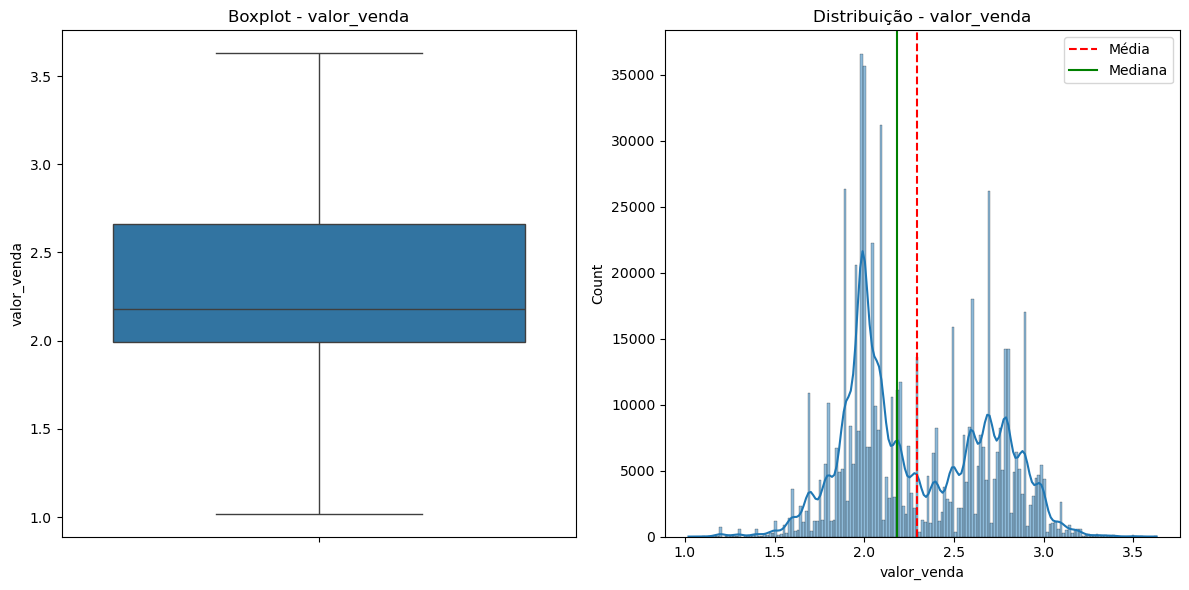


============================== VALOR DE COMPRA (Z-Score) ==============================
🔍 Análise de Outliers - valor_compra
Método: Z-Score (limite: 3)
Total de outliers: 1599 (0.25% dos dados)
Valor mínimo: 0.6041
Q1 (25%): 1.7469
Mediana (50%): 1.8690
Q3 (75%): 2.2800
Valor máximo: 2.9982


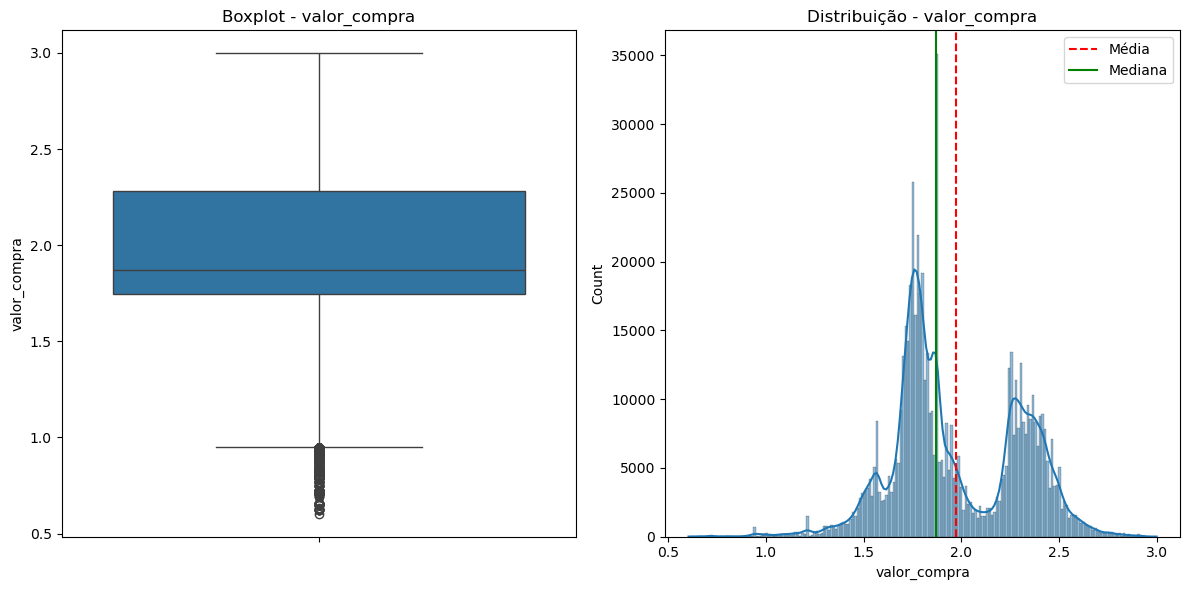


📊 ANÁLISE DE OUTLIERS - SEGUNDO SEMESTRE

============================== VALOR DE VENDA (IQR) ==============================
🔍 Análise de Outliers - valor_venda
Método: IQR (limite: 1.5 × IQR)
Total de outliers: 0 (0.00% dos dados)
Valor mínimo: 1.0990
Q1 (25%): 1.9900
Mediana (50%): 2.1900
Q3 (75%): 2.6900
Valor máximo: 3.7190


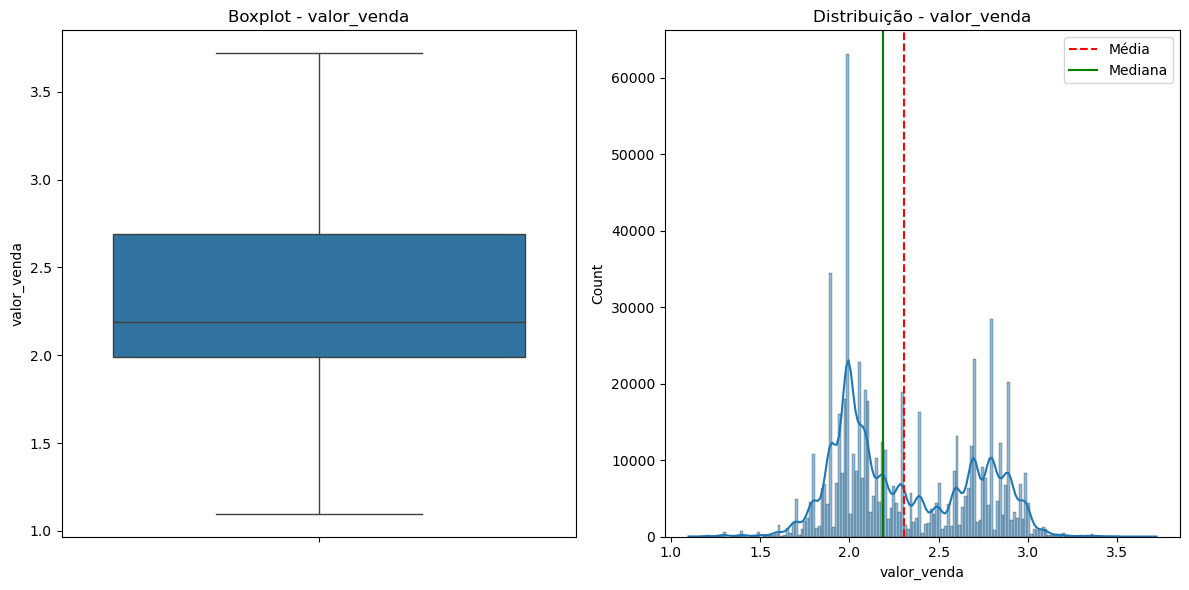


============================== VALOR DE COMPRA (Z-Score) ==============================
🔍 Análise de Outliers - valor_compra
Método: Z-Score (limite: 3)
Total de outliers: 1880 (0.29% dos dados)
Valor mínimo: 0.6309
Q1 (25%): 1.7596
Mediana (50%): 1.9074
Q3 (75%): 2.2861
Valor máximo: 2.9800


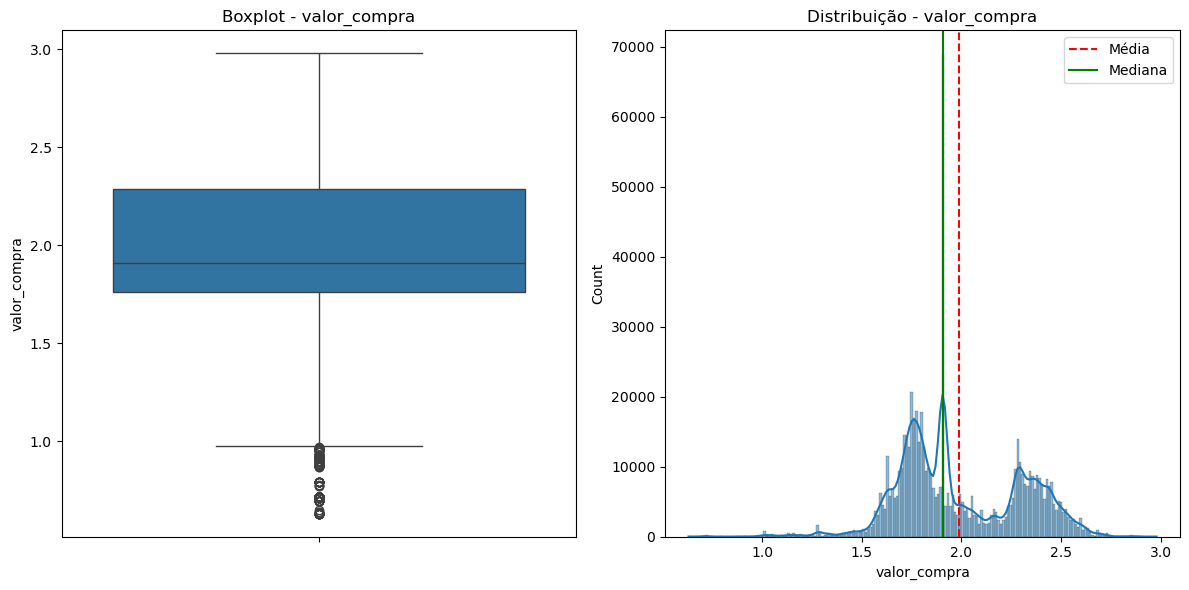


✅ Análise de outliers concluída para ambos os períodos!


In [14]:
import numpy as np
from scipy import stats

def identificar_outliers(df, coluna, metodo='iqr', limite=1.5):
    """
    Identifica outliers em uma coluna numérica usando IQR ou Z-Score.
    
    Parâmetros:
    - df: DataFrame
    - coluna: Nome da coluna para análise
    - metodo: 'iqr' (padrão) ou 'zscore'
    - limite: Fator de multiplicação do IQR ou limiar do Z-Score
    
    Retorna:
    - DataFrame com informações sobre os outliers
    - Gráfico boxplot
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Criar cópia para não modificar o original
    data = df[[coluna]].copy()
    
    if metodo.lower() == 'iqr':
        # Método IQR
        Q1 = data[coluna].quantile(0.25)
        Q3 = data[coluna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - limite * IQR
        limite_superior = Q3 + limite * IQR
        
        # Identificar outliers
        outliers = data[(data[coluna] < limite_inferior) | (data[coluna] > limite_superior)]
        metodo_nome = f'IQR (limite: {limite} × IQR)'
        
    elif metodo.lower() == 'zscore':
        # Método Z-Score
        z_scores = np.abs(stats.zscore(data[coluna]))
        outliers = data[z_scores > limite]
        metodo_nome = f'Z-Score (limite: {limite})'
    
    else:
        raise ValueError("Método não reconhecido. Use 'iqr' ou 'zscore'")
    
    # Estatísticas
    total_outliers = len(outliers)
    percentual = (total_outliers / len(data)) * 100
    
    print(f"🔍 Análise de Outliers - {coluna}")
    print("="*50)
    print(f"Método: {metodo_nome}")
    print(f"Total de outliers: {total_outliers} ({percentual:.2f}% dos dados)")
    print(f"Valor mínimo: {data[coluna].min():.4f}")
    print(f"Q1 (25%): {data[coluna].quantile(0.25):.4f}")
    print(f"Mediana (50%): {data[coluna].median():.4f}")
    print(f"Q3 (75%): {data[coluna].quantile(0.75):.4f}")
    print(f"Valor máximo: {data[coluna].max():.4f}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data[coluna])
    plt.title(f'Boxplot - {coluna}')
    
    # Histograma com KDE
    plt.subplot(1, 2, 2)
    sns.histplot(data[coluna], kde=True)
    plt.axvline(data[coluna].mean(), color='red', linestyle='--', label='Média')
    plt.axvline(data[coluna].median(), color='green', linestyle='-', label='Mediana')
    plt.title(f'Distribuição - {coluna}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return outliers

# Análise para o Primeiro Semestre (df_1s)
print("="*70)
print("📊 ANÁLISE DE OUTLIERS - PRIMEIRO SEMESTRE")
print("="*70)

# Análise de valor_venda com IQR
print("\n" + "="*30 + " VALOR DE VENDA (IQR) " + "="*30)
outliers_venda_1s = identificar_outliers(df_1s, 'valor_venda', metodo='iqr')

# Análise de valor_compra com Z-Score
print("\n" + "="*30 + " VALOR DE COMPRA (Z-Score) " + "="*30)
outliers_compra_1s = identificar_outliers(df_1s, 'valor_compra', metodo='zscore', limite=3)

# Análise para o Segundo Semestre (df_2s)
print("\n" + "="*70)
print("📊 ANÁLISE DE OUTLIERS - SEGUNDO SEMESTRE")
print("="*70)

# Análise de valor_venda com IQR
print("\n" + "="*30 + " VALOR DE VENDA (IQR) " + "="*30)
outliers_venda_2s = identificar_outliers(df_2s, 'valor_venda', metodo='iqr')

# Análise de valor_compra com Z-Score
print("\n" + "="*30 + " VALOR DE COMPRA (Z-Score) " + "="*30)
outliers_compra_2s = identificar_outliers(df_2s, 'valor_compra', metodo='zscore', limite=3)

print("\n✅ Análise de outliers concluída para ambos os períodos!")

# 📊 Validação de Faixas de Preços

## 🎯 Objetivo
Garantir que os valores de preços estejam dentro de faixas razoáveis e identificar possíveis erros de registro.

## 🔍 O que é Validado

### 1. Valores Negativos
| Característica | Detalhe |
| :--- | :--- |
| **O que verifica** | Preços menores que zero |
| **Por que é importante** | Preços não podem ser negativos |
| **Ação recomendada** | Investigar e corrigir |

### 2. Valores Zerados
| Característica | Detalhe |
| :--- | :--- |
| **O que verifica** | Preços iguais a zero |
| **Por que é importante** | Pode indicar dados faltantes ou erros de digitação |
| **Ação recomendada** | Verificar se é um valor legítimo |

### 3. Faixas Esperadas
| Tipo de Valor | Faixa Esperada | Por que é Importante |
| :--- | :--- | :--- |
| **Valor de Venda** | Entre R\$ 0,50 e R\$ 5,00 | Identificar erros de digitação ou medição |
| **Valor de Compra** | Entre R\$ 0,30 e R\$ 4,50 | Identificar erros de digitação ou medição |

## 📈 Métricas Analisadas

### Estatísticas Descritivas
* Contagem de registros
* Média e mediana
* Desvio padrão
* Valores mínimos e máximos
* Quartis (25%, 50%, 75%)

### Visualizações
* Histograma da distribuição
* Linhas de média e mediana
* Identificação visual de outliers (ex: Boxplot)

## ⚠️ Possíveis Problemas

### 1. Valores Fora da Faixa
* **Sintomas:** Valores muito acima ou abaixo do esperado
* **Causas possíveis:**
    * Erros de digitação
    * Unidades de medida incorretas
    * Dados de períodos atípicos

### 2. Distribuição Assimétrica
* **Sintomas:** Média muito diferente da mediana
* **Impacto:** Pode afetar análises estatísticas
* **Solução:** Considerar transformação dos dados

## ✅ Próximos Passos
1. Analisar os registros com valores suspeitos
2. Documentar as decisões de tratamento
3. Aplicar as correções necessárias
4. Repetir a validação após correções

## 📝 Notas
* As faixas podem ser ajustadas conforme o conhecimento de domínio.
* Considere o contexto histórico dos preços.
* Documente quaisquer alterações realizadas nos dados.


🔍 VALIDAÇÃO DE FAIXAS DE PREÇOS - PRIMEIRO SEMESTRE

📊 Análise de valor_venda:
--------------------------------------------------
✅ Nenhum valor negativo encontrado
✅ Nenhum valor zero encontrado
✅ Nenhum valor abaixo de 0.5 encontrado
✅ Nenhum valor acima de 5.0 encontrado

📈 Estatísticas descritivas:
count    649693.000000
mean          2.293604
std           0.396286
min           1.020000
25%           1.990000
50%           2.180000
75%           2.660000
max           3.629000


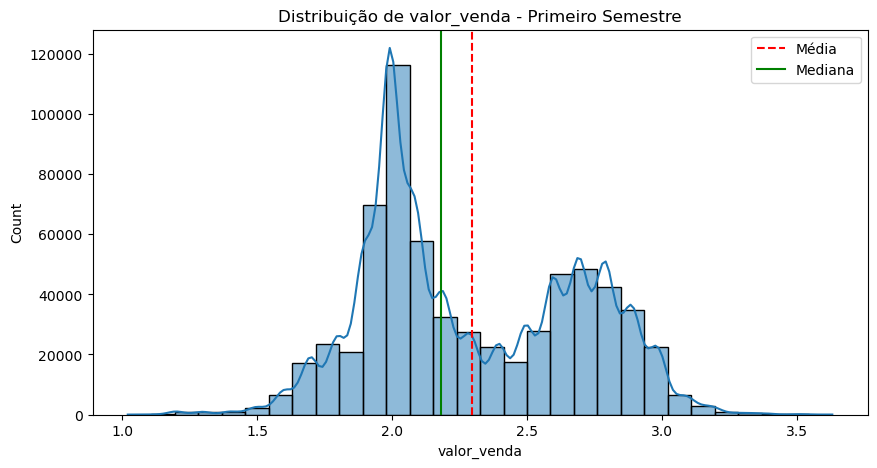


📊 Análise de valor_compra:
--------------------------------------------------
✅ Nenhum valor negativo encontrado
✅ Nenhum valor zero encontrado
✅ Nenhum valor abaixo de 0.3 encontrado
✅ Nenhum valor acima de 4.5 encontrado

📈 Estatísticas descritivas:
count    649693.000000
mean          1.970556
std           0.325316
min           0.604100
25%           1.746900
50%           1.869000
75%           2.280000
max           2.998200


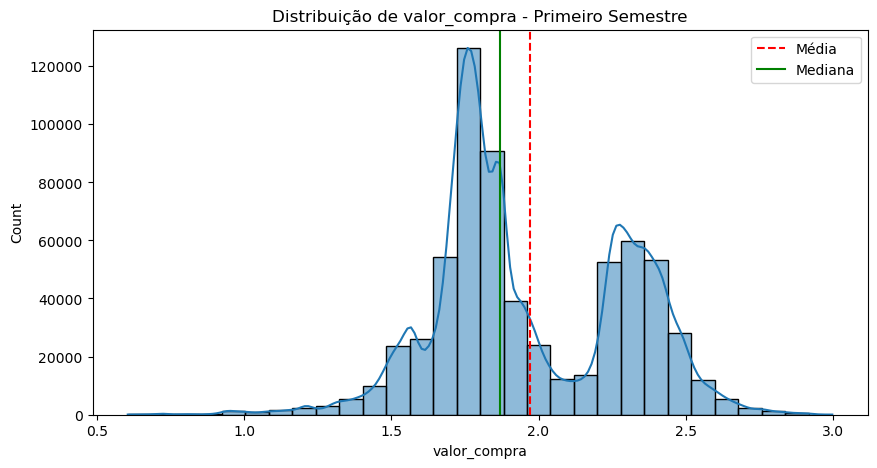


🔍 VALIDAÇÃO DE FAIXAS DE PREÇOS - SEGUNDO SEMESTRE

📊 Análise de valor_venda:
--------------------------------------------------
✅ Nenhum valor negativo encontrado
✅ Nenhum valor zero encontrado
✅ Nenhum valor abaixo de 0.5 encontrado
✅ Nenhum valor acima de 5.0 encontrado

📈 Estatísticas descritivas:
count    650008.000000
mean          2.306979
std           0.386567
min           1.099000
25%           1.990000
50%           2.190000
75%           2.690000
max           3.719000


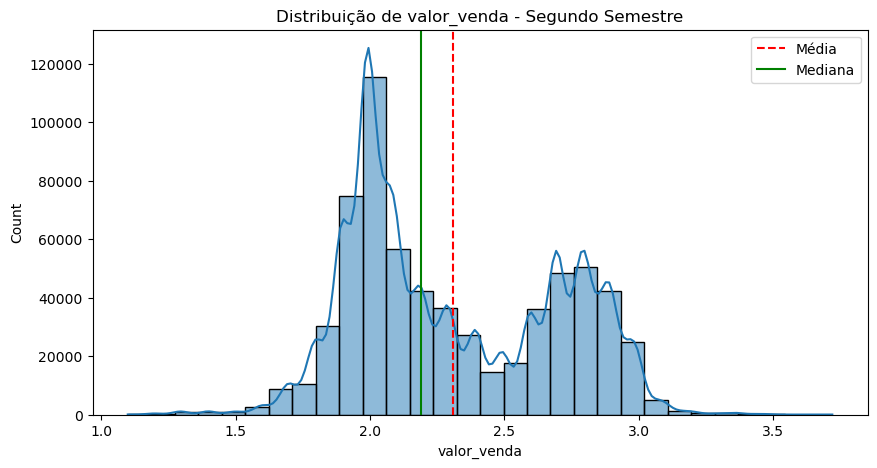


📊 Análise de valor_compra:
--------------------------------------------------
✅ Nenhum valor negativo encontrado
✅ Nenhum valor zero encontrado
✅ Nenhum valor abaixo de 0.3 encontrado
✅ Nenhum valor acima de 4.5 encontrado

📈 Estatísticas descritivas:
count    650008.000000
mean          1.990421
std           0.308484
min           0.630900
25%           1.759600
50%           1.907350
75%           2.286100
max           2.980000


In [ ]:
def validar_faixas_precos(df, nome_periodo):
    """
    Valida as faixas de preços e identifica valores fora do esperado.
    
    Parâmetros:
    - df: DataFrame com os dados
    - nome_periodo: Nome do período para exibição
    """
    print(f"\n🔍 VALIDAÇÃO DE FAIXAS DE PREÇOS - {nome_periodo.upper()}")
    print("="*70)
    
    # Dicionário com faixas esperadas (ajuste conforme necessário)
    faixas = {
        'valor_venda': {'min': 0.5, 'max': 5.0},
        'valor_compra': {'min': 0.3, 'max': 4.5}
    }
    
    for coluna, limites in faixas.items():
        print(f"\n📊 Análise de {coluna}:")
        print("-"*50)
        
        # Verificar valores negativos
        negativos = df[df[coluna] < 0]
        if not negativos.empty:
            print(f"⚠️  AVISO: {len(negativos)} valores negativos encontrados!")
            print("Amostra dos registros com valores negativos:")
            display(negativos.head())
        else:
            print("✅ Nenhum valor negativo encontrado")
        
        # Verificar valores zero
        zeros = df[df[coluna] == 0]
        if not zeros.empty:
            print(f"⚠️  AVISO: {len(zeros)} valores iguais a zero encontrados!")
            print("Amostra dos registros com valor zero:")
            display(zeros.head())
        else:
            print("✅ Nenhum valor zero encontrado")
        
        # Verificar valores abaixo do mínimo esperado
        abaixo_min = df[df[coluna] < limites['min']]
        if not abaixo_min.empty:
            print(f"⚠️  AVISO: {len(abaixo_min)} valores abaixo de {limites['min']} encontrados!")
            print(f"Valor mínimo encontrado: {df[coluna].min():.4f}")
            print("Amostra dos registros com valores baixos:")
            display(abaixo_min.head())
        else:
            print(f"✅ Nenhum valor abaixo de {limites['min']} encontrado")
        
        # Verificar valores acima do máximo esperado
        acima_max = df[df[coluna] > limites['max']]
        if not acima_max.empty:
            print(f"⚠️  AVISO: {len(acima_max)} valores acima de {limites['max']} encontrados!")
            print(f"Valor máximo encontrado: {df[coluna].max():.4f}")
            print("Amostra dos registros com valores altos:")
            display(acima_max.head())
        else:
            print(f"✅ Nenhum valor acima de {limites['max']} encontrado")
        
        # Estatísticas descritivas
        print("\n📈 Estatísticas descritivas:")
        print(df[coluna].describe().to_string())
        
        # Histograma
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(10, 5))
        sns.histplot(df[coluna], bins=30, kde=True)
        plt.axvline(df[coluna].mean(), color='red', linestyle='--', label='Média')
        plt.axvline(df[coluna].median(), color='green', linestyle='-', label='Mediana')
        plt.title(f'Distribuição de {coluna} - {nome_periodo}')
        plt.legend()
        plt.show()

# Executar a validação para ambos os períodos
validar_faixas_precos(df_1s, "Primeiro Semestre")
validar_faixas_precos(df_2s, "Segundo Semestre")

print("\n✅ Validação de faixas concluída para ambos os períodos!")

# 📊 Validador e Corretor de Dados Geográficos

## 📌 Visão Geral
Este script valida e corrige automaticamente os nomes dos municípios brasileiros em seus dados, comparando-os com a base oficial do IBGE.

## 🛠️ Funções Principais

### 1. `carregar_municipios_ibge()`
- **O que faz**: Baixa a lista completa de municípios brasileiros da API do IBGE
- **Retorna**: Dados brutos dos municípios em formato JSON
- **Tratamento de erros**: Inclui tentativas de reconexão e mensagens claras

### 2. `criar_dicionario_municipios()`
- **O que faz**: Processa os dados do IBGE e cria um dicionário de referência
- **Formato**: `{(UF, NOME_SEM_ACENTO): NOME_ORIGINAL}`
- **Exemplo**: `{('SP', 'SAO PAULO'): 'SÃO PAULO'}`

### 3. `corrigir_nome_municipio(uf, nome, dicionario)`
- **O que faz**: Corrige o nome de um município com base no dicionário
- **Lógica de correção**:
  1. Tenta encontrar correspondência exata (UF + nome sem acento)
  2. Se não encontrar, busca similaridades no nome
  3. Retorna o nome original se não encontrar correspondência

### 4. `verificar_e_corrigir_municipios(df)`
- **Entrada**: DataFrame com colunas 'municipio' e 'estado_sigla'
- **Saída**: DataFrame com correções aplicadas e colunas adicionais:
  - `municipio_original`: Nome original do município
  - `correcao_aplicada`: Booleano indicando se houve correção

## 📊 Saída do Programa
- Total de registros processados
- Quantidade e percentual de correções aplicadas
- Exemplos das correções realizadas
- Estatísticas por estado (quando aplicável)

## 🚀 Como Usar
```python
# Aplicar a correção em um DataFrame
df_corrigido = verificar_e_corrigir_municipios(seu_dataframe)

# Visualizar as correções
print(f"Total de correções: {df_corrigido['correcao_aplicada'].sum()}")
print("Exemplos de correções:")
display(df_corrigido[df_corrigido['correcao_aplicada']].head())

In [ ]:
import pandas as pd
import requests
from unidecode import unidecode
from tqdm import tqdm
import time
from typing import Dict, Set, Tuple, Optional, Any, List
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import lru_cache
import logging
from difflib import get_close_matches
import re
import unicodedata

# Configuração de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

class ValidadorGeografico:
    """Classe para validação e correção de dados geográficos brasileiros."""
    
    # Cache para armazenar os dados do IBGE
    _CACHE_IBGE = None
    _ULTIMA_ATUALIZACAO_IBGE = 0
    _CACHE_TEMPO_VIDA = 86400  # 24 horas em segundos
    
    # Regiões do Brasil
    REGIOES_BRASIL = {
        'Norte': {'sigla': 'N', 'estados': {'AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'}},
        'Nordeste': {'sigla': 'NE', 'estados': {'AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'}},
        'Centro-Oeste': {'sigla': 'CO', 'estados': {'DF', 'GO', 'MT', 'MS'}},
        'Sudeste': {'sigla': 'SE', 'estados': {'ES', 'MG', 'RJ', 'SP'}},
        'Sul': {'sigla': 'S', 'estados': {'PR', 'RS', 'SC'}}
    }
    
    def __init__(self, max_tentativas: int = 3, timeout: int = 60):
        """
        Inicializa o validador geográfico.
        
        Args:
            max_tentativas: Número máximo de tentativas para carregar dados do IBGE
            timeout: Tempo máximo de espera para requisições HTTP
        """
        self.max_tentativas = max_tentativas
        self.timeout = timeout
        self.estado_para_regiao = self._criar_mapa_estado_regiao()
        self.municipios_por_uf = self._carregar_municipios_ibge()
        self._cache_nomes_oficiais = {}
        self._variacoes_comuns = {
            'D O ': 'DO ',
            'D A ': 'DA ',
            'D OS ': 'DOS ',
            'D AS ': 'DAS ',
            'D E ': 'DE ',
            'SAO ': 'SÃO ',
            ' SAO': ' SÃO',
            'S. ': 'SÃO ',
            ' S.': ' SÃO',
            'S.': 'SÃO',
            'ESPIGAO ': 'ESPIGÃO ',
            'SANTANA DO LIVRAMENTO': "SANT'ANA DO LIVRAMENTO",
            'BELEM': 'BELÉM',
            'GOIANIA': 'GOIÂNIA',
            'MANAUS': 'MANAÚS',
            'PARANA': 'PARANÁ',
            'PARAIBA': 'PARAÍBA',
            'PIAUI': 'PIAUÍ',
            'SAO PAULO': 'SÃO PAULO',
            'SAO LUIS': 'SÃO LUÍS'
        }
        self._compiled_variations = {re.compile(r'\b' + re.escape(k) + r'\b'): v 
                                   for k, v in self._variacoes_comuns.items()}

    def _criar_mapa_estado_regiao(self) -> Dict[str, Dict[str, str]]:
        """Cria um dicionário mapeando UF para suas informações de região."""
        return {
            uf: {'regiao': regiao, 'sigla': info['sigla']}
            for regiao, info in self.REGIOES_BRASIL.items()
            for uf in info['estados']
        }

    @lru_cache(maxsize=1)
    def _carregar_municipios_ibge(self) -> Dict[str, Dict[str, str]]:
        """Carrega e armazena em cache os municípios do IBGE."""
        current_time = time.time()
        
        # Verificar se já temos dados em cache
        if (self._CACHE_IBGE is not None and 
            (current_time - self._ULTIMA_ATUALIZACAO_IBGE) < self._CACHE_TEMPO_VIDEA):
            logger.info("Retornando dados do IBGE em cache")
            return self._CACHE_IBGE
        
        logger.info("Atualizando cache de municípios do IBGE...")
        municipios_por_uf = {}
        
        # Tentar carregar de um arquivo local primeiro
        try:
            import json
            import os
            cache_file = "municipios_ibge_cache.json"
            
            # Se o arquivo de cache existe e tem menos de 7 dias
            if os.path.exists(cache_file) and (time.time() - os.path.getmtime(cache_file)) < (7 * 24 * 60 * 60):
                with open(cache_file, 'r', encoding='utf-8') as f:
                    municipios_por_uf = json.load(f)
                    logger.info(f"✅ Dados carregados do cache local ({cache_file})")
                    return municipios_por_uf
        except Exception as e:
            logger.warning(f"Não foi possível carregar do cache local: {e}")
        
        # Se não encontrou no cache local, tenta a API
        for tentativa in range(1, self.max_tentativas + 1):
            try:
                url = "https://servicodados.ibge.gov.br/api/v1/localidades/municipios"
                logger.info(f"Tentativa {tentativa}/{self.max_tentativas} - Acessando {url}")
                
                response = requests.get(url, timeout=self.timeout)
                response.raise_for_status()
                municipios = response.json()
                
                if not isinstance(municipios, list):
                    raise ValueError("Resposta da API não é uma lista de municípios")
                
                # Processar os municípios
                for mun in municipios:
                    try:
                        uf = mun.get('microrregiao', {}).get('mesorregiao', {}).get('UF', {}).get('sigla')
                        nome = mun.get('nome')
                        
                        if not uf or not nome:
                            continue
                        
                        # Normalizar o nome
                        nome_normalizado = self._normalizar_nome(nome)
                        if uf not in municipios_por_uf:
                            municipios_por_uf[uf] = {}
                        
                        # Armazenar o nome original mapeado para o normalizado
                        municipios_por_uf[uf][nome_normalizado] = nome
                        
                    except Exception as e:
                        logger.warning(f"Erro ao processar município {mun.get('id')}: {e}")
                        continue
                
                # Salvar no cache local
                try:
                    with open(cache_file, 'w', encoding='utf-8') as f:
                        json.dump(municipios_por_uf, f, ensure_ascii=False, indent=2)
                    logger.info(f"✅ Dados salvos em cache local ({cache_file})")
                except Exception as e:
                    logger.warning(f"Não foi possível salvar o cache local: {e}")
                
                # Atualizar cache em memória
                self._CACHE_IBGE = municipios_por_uf
                self._ULTIMA_ATUALIZACAO_IBGE = current_time
                
                logger.info(f"✅ Dados processados para {len(municipios_por_uf)} UFs")
                return municipios_por_uf
                
            except requests.exceptions.RequestException as e:
                logger.error(f"Erro na requisição ao IBGE (tentativa {tentativa}): {e}")
                if tentativa < self.max_tentativas:
                    wait_time = 2 ** tentativa
                    logger.info(f"Aguardando {wait_time} segundos antes de tentar novamente...")
                    time.sleep(wait_time)
            except Exception as e:
                logger.error(f"Erro inesperado ao carregar municípios: {str(e)}")
                break
        
        # Se chegou aqui, não conseguiu carregar da API
        logger.error("❌ Não foi possível carregar os dados do IBGE após várias tentativas")
        
        # Tenta carregar uma lista básica de municípios como fallback
        logger.info("Carregando lista básica de municípios como fallback...")
        municipios_por_uf = {
            'SP': {'SAO PAULO': 'São Paulo', 'CAMPINAS': 'Campinas'},
            'RJ': {'RIO DE JANEIRO': 'Rio de Janeiro', 'NITEROI': 'Niterói'},
            # Adicione mais municípios conforme necessário
        }
        
        return municipios_por_uf

    def _processar_lote_municipios(self, lote: list) -> Dict[str, Dict[str, str]]:
        """Processa um lote de municípios em paralelo."""
        resultado = {}
        for mun in lote:
            try:
                uf = mun.get('microrregiao', {}).get('mesorregiao', {}).get('UF', {}).get('sigla')
                nome = mun.get('nome')
                
                if not uf or not nome:
                    continue
                
                # Manter o nome original para exibição
                nome_original = str(nome).strip()
                
                # Normalizar para comparação
                nome_normalizado = self._normalizar_nome(nome_original)
                
                if uf not in resultado:
                    resultado[uf] = {}
                
                # Armazenar o nome original mapeado para o normalizado
                resultado[uf][nome_normalizado] = nome_original
            except Exception as e:
                logger.warning(f"Erro ao processar município: {e}")
                continue
        return resultado

    def _normalizar_nome(self, nome: str) -> str:
        """Normaliza o nome para comparação, aplicando variações comuns."""
        if pd.isna(nome):
            return ''
            
        # Converter para string e remover espaços extras
        nome = str(nome).strip().upper()
        
        # Aplicar variações comuns
        for pattern, replacement in self._compiled_variations.items():
            nome = pattern.sub(replacement, nome)
            
        # Remover acentos e caracteres especiais
        nome = ''.join(c for c in unicodedata.normalize('NFD', nome) 
                      if unicodedata.category(c) != 'Mn')
        
        # Remover múltiplos espaços
        nome = re.sub(r'\s+', ' ', nome).strip()
        
        return nome

    def _encontrar_melhor_correspondencia(self, uf: str, nome: str, limiar: float = 0.7) -> Tuple[bool, str]:
        """
        Encontra a melhor correspondência para um município usando difflib.
        
        Args:
            uf: Sigla da UF
            nome: Nome do município a ser verificado
            limiar: Limiar de similaridade (0-1)
            
        Returns:
            Tupla (corrigido, nome_corrigido)
        """
        if pd.isna(uf) or not nome:
            return False, nome
            
        uf = str(uf).upper()
        nome = self._normalizar_nome(nome)
        
        # Verificar se a UF existe no dicionário
        if uf not in self.municipios_por_uf:
            return False, nome
        
        # 1. Verificar correspondência exata
        if nome in self.municipios_por_uf[uf]:
            return False, self._obter_nome_oficial(uf, nome)
        
        # 2. Tentar encontrar correspondência aproximada
        municipios_uf = list(self.municipios_por_uf[uf].keys())
        matches = get_close_matches(nome, municipios_uf, n=1, cutoff=limiar)
        
        if matches:
            return True, self._obter_nome_oficial(uf, matches[0])
        
        # 3. Tentar remover "DO", "DA", "DOS", "DAS" e verificar novamente
        nome_simplificado = re.sub(r'\b(DO|DA|DOS|DAS|DE)\b', '', nome).strip()
        nome_simplificado = re.sub(r'\s+', ' ', nome_simplificado)
        
        if nome_simplificado != nome:
            matches = get_close_matches(nome_simplificado, 
                                      [re.sub(r'\b(DO|DA|DOS|DAS|DE)\b', '', m).strip() 
                                       for m in municipios_uf], 
                                      n=1, 
                                      cutoff=limiar)
            if matches:
                idx = [re.sub(r'\b(DO|DA|DOS|DAS|DE)\b', '', m).strip() 
                      for m in municipios_uf].index(matches[0])
                return True, self._obter_nome_oficial(uf, municipios_uf[idx])
        
        # 4. Tentar correspondência parcial
        for municipio_normalizado, municipio_oficial in self.municipios_por_uf[uf].items():
            # Verificar se um está contido no outro
            if (nome in municipio_normalizado or municipio_normalizado in nome) and len(municipio_normalizado) > 5:
                return True, municipio_oficial
        
        return False, nome

    def _obter_nome_oficial(self, uf: str, nome_normalizado: str) -> str:
        """Obtém o nome oficial do município a partir do nome normalizado."""
        # Se o nome já está na forma oficial, retorná-lo
        if uf in self.municipios_por_uf and nome_normalizado in self.municipios_por_uf[uf]:
            return self.municipios_por_uf[uf][nome_normalizado]
        return nome_normalizado

    def validar_consistencia_geografica(self, df: pd.DataFrame, nome_periodo: str) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        """
        Valida a consistência geográfica dos dados.
        
        Args:
            df: DataFrame com as colunas 'municipio' e 'estado_sigla'
            nome_periodo: Nome do período para fins de log
            
        Returns:
            Tuple contendo o DataFrame com validações e um dicionário com o relatório
        """
        logger.info(f"\n🔍 VALIDAÇÃO DE CONSISTÊNCIA GEOGRÁFICA - {nome_periodo.upper()}")
        logger.info("="*80)
        
        if df.empty:
            logger.warning("DataFrame vazio recebido para validação")
            return df, {}
        
        # Criar cópia para não modificar o original
        df = df.copy()
        
        # 1. Validar estrutura do DataFrame
        colunas_necessarias = {'municipio', 'estado_sigla', 'regiao_sigla'}
        if not colunas_necessarias.issubset(df.columns):
            missing = colunas_necessarias - set(df.columns)
            raise ValueError(f"Colunas obrigatórias não encontradas: {missing}")
        
        # 2. Validar regiões
        relatorio = self._validar_regioes(df)
        
        # 3. Validar municípios
        if self.municipios_por_uf:
            validacoes = self._validar_municipios(df, relatorio)
            relatorio['municipios_validados'] = validacoes
        else:
            logger.warning("Não foi possível validar municípios - dados do IBGE indisponíveis")
        
        # 4. Gerar relatório final
        self._gerar_relatorio_final(relatorio)
        
        return df, relatorio

    def _validar_regioes(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Valida a consistência das regiões."""
        relatorio = {
            'total_registros': len(df),
            'estados_unicos': df['estado_sigla'].nunique(),
            'municipios_unicos': df['municipio'].nunique(),
            'regioes': list(df['regiao_sigla'].unique()),
            'inconsistencias_regiao': 0,
            'estados_sem_regiao': [],
            'municipios_invalidos': 0,
            'percentual_invalidos': 0.0
        }
        
        # Verificar estados sem região definida
        estados_presentes = set(df['estado_sigla'].dropna().unique())
        estados_sem_regiao = estados_presentes - set(self.estado_para_regiao.keys())
        
        if estados_sem_regiao:
            logger.warning(f"⚠️  Estados sem região definida: {', '.join(estados_sem_regiao)}")
            relatorio['estados_sem_regiao'] = list(estados_sem_regiao)
        else:
            logger.info("✅ Todos os estados têm região definida corretamente")
        
        # Verificar consistência entre estado_sigla e regiao_sigla
        regioes_corretas = df['estado_sigla'].map(
            lambda x: self.estado_para_regiao.get(x, {}).get('sigla') if pd.notna(x) else None
        )
        
        inconsistencias = df[df['regiao_sigla'] != regioes_corretas]
        if not inconsistencias.empty:
            logger.warning(f"⚠️  {len(inconsistencias)} registros com inconsistência entre estado e região")
            logger.info("Amostra das inconsistências:")
            logger.info(inconsistencias[['estado_sigla', 'regiao_sigla']].head().to_string())
            relatorio['inconsistencias_regiao'] = len(inconsistencias)
        else:
            logger.info("✅ Todas as regiões estão consistentes com os estados")
        
        return relatorio

    def _validar_municipios(self, df: pd.DataFrame, relatorio: Dict[str, Any]) -> List[bool]:
        """Valida os municípios contra a base do IBGE."""
        logger.info("\n🔍 Validando municípios contra a base do IBGE...")
        
        validacoes = []
        total_invalidos = 0
        exemplos_invalidos = set()
        max_exemplos = 5
        
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Validando municípios"):
            uf = str(row['estado_sigla']).upper() if pd.notna(row['estado_sigla']) else None
            municipio = str(row['municipio']).strip() if pd.notna(row['municipio']) else ''
            
            valido = False
            if uf and municipio and uf in self.municipios_por_uf:
                # Verificar se o município normalizado existe
                municipio_normalizado = self._normalizar_nome(municipio)
                valido = municipio_normalizado in self.municipios_por_uf[uf]
            
            if not valido and len(exemplos_invalidos) < max_exemplos:
                exemplos_invalidos.add(f"'{municipio}' em {uf}")
                
            if not valido:
                total_invalidos += 1
                
            validacoes.append(valido)
        
        percentual_invalidos = (total_invalidos / len(validacoes)) * 100 if validacoes else 0
        
        relatorio.update({
            'municipios_invalidos': int(total_invalidos),
            'percentual_invalidos': float(f"{percentual_invalidos:.2f}")
        })
        
        logger.info(f"\n📊 Resultado da validação de municípios:")
        logger.info(f"✅ Municípios válidos: {len(validacoes) - total_invalidos:,} ({(100 - percentual_invalidos):.2f}%)")
        logger.info(f"⚠️  Municípios inválidos: {total_invalidos:,} ({percentual_invalidos:.2f}%)")
        
        # Mostrar exemplos de municípios inválidos
        if exemplos_invalidos:
            logger.info("\n🔍 Exemplos de municípios inválidos:")
            for exemplo in exemplos_invalidos:
                logger.info(f"   - {exemplo}")
        
        return validacoes

    def _gerar_relatorio_final(self, relatorio: Dict[str, Any]) -> None:
        """Gera o relatório final da validação."""
        logger.info("\n📊 Estatísticas Geográficas:")
        logger.info(f"Total de registros: {relatorio['total_registros']:,}")
        logger.info(f"Estados únicos: {relatorio['estados_unicos']}")
        logger.info(f"Municípios únicos: {relatorio['municipios_unicos']}")
        logger.info(f"Regiões: {', '.join(relatorio['regioes'])}")
        
        if relatorio.get('municipios_invalidos', 0) > 0:
            logger.warning(
                f"⚠️  Atenção: {relatorio['municipios_invalidos']:,} "
                f"({relatorio['percentual_invalidos']}%) municípios inválidos encontrados"
            )

    def corrigir_municipios(self, df: pd.DataFrame, limiar_similaridade: float = 0.7) -> pd.DataFrame:
        """
        Corrige automaticamente os nomes dos municípios com base na base do IBGE.
        
        Args:
            df: DataFrame com as colunas 'municipio' e 'estado_sigla'
            limiar_similaridade: Limiar de similaridade (0-1) para considerar correção automática
            
        Returns:
            DataFrame com os nomes dos municípios corrigidos
        """
        if df.empty:
            logger.warning("DataFrame vazio recebido para correção")
            return df
        
        # Criar cópia para não modificar o original
        df = df.copy()
        
        # Verificar se as colunas necessárias existem
        colunas_necessarias = {'municipio', 'estado_sigla'}
        if not colunas_necessarias.issubset(df.columns):
            missing = colunas_necessarias - set(df.columns)
            raise ValueError(f"Colunas obrigatórias não encontradas: {missing}")
        
        logger.info("\n🔧 Iniciando correção automática de municípios...")
        
        # Inicializar contadores
        total_corrigidos = 0
        correcoes = []
        max_exemplos = 5
        
        # Processar cada linha
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processando correções"):
            uf = row['estado_sigla']
            municipio = row['municipio']
            
            # Pular valores ausentes
            if pd.isna(uf) or pd.isna(municipio):
                continue
                
            # Tentar encontrar a melhor correspondência
            corrigido, novo_nome = self._encontrar_melhor_correspondencia(uf, municipio, limiar_similaridade)
            
            # Se encontrou uma correção, aplicar
            if corrigido and novo_nome != municipio:
                df.at[idx, 'municipio'] = novo_nome
                if len(correcoes) < max_exemplos:
                    correcoes.append((municipio, novo_nome, uf))
                total_corrigidos += 1
        
        # Registrar estatísticas
        percentual = (total_corrigidos / len(df)) * 100 if len(df) > 0 else 0
        logger.info(f"\n📊 Resultado da correção automática:")
        logger.info(f"✅ Total de registros processados: {len(df):,}")
        logger.info(f"✅ Municípios corrigidos: {total_corrigidos:,} ({percentual:.2f}%)")
        
        # Mostrar exemplos de correções
        if correcoes:
            logger.info("\n🔍 Exemplos de correções aplicadas:")
            for antigo, novo, uf in correcoes:
                logger.info(f"   - {uf}: '{antigo}' → '{novo}'")
            if total_corrigidos > max_exemplos:
                logger.info(f"   ... e mais {total_corrigidos - max_exemplos} correções")
        else:
            logger.info("ℹ️  Nenhuma correção necessária")
            
        return df

if __name__ == "__main__":
    # Criar instância do validador
    validador = ValidadorGeografico()
    
    # Verificar se os DataFrames existem no escopo global
    import __main__
    if 'df_1s' in vars(__main__) and 'df_2s' in vars(__main__):
        # Processar primeiro semestre
        print("="*80)
        print("PROCESSANDO PRIMEIRO SEMESTRE")
        print("="*80)
        
        # Validar consistência
        df_1s_validado, relatorio_1s = validador.validar_consistencia_geografica(df_1s, "Primeiro Semestre")
        
        # Aplicar correções (ajustado para a nova escala 0-1)
        df_1s_corrigido = validador.corrigir_municipios(df_1s_validado, limiar_similaridade=0.85)
        
        # Validar novamente após correções
        df_1s_final, relatorio_1s_final = validador.validar_consistencia_geografica(
            df_1s_corrigido, 
            "Primeiro Semestre (Corrigido)"
        )
        
        # Processar segundo semestre
        print("\n" + "="*80)
        print("PROCESSANDO SEGUNDO SEMESTRE")
        print("="*80)
        
        # Validar consistência
        df_2s_validado, relatorio_2s = validador.validar_consistencia_geografica(df_2s, "Segundo Semestre")
        
        # Aplicar correções (ajustado para a nova escala 0-1)
        df_2s_corrigido = validador.corrigir_municipios(df_2s_validado, limiar_similaridade=0.85)
        
        # Validar novamente após correções
        df_2s_final, relatorio_2s_final = validador.validar_consistencia_geografica(
            df_2s_corrigido,
            "Segundo Semestre (Corrigido)"
        )
        
        # Mostrar resumo final
        print("\n" + "="*80)
        print("RESUMO FINAL")
        print("="*80)
        print(f"Primeiro Semestre - Registros: {len(df_1s_final):,}")
        print(f"  - Municípios inválidos iniciais: {relatorio_1s.get('municipios_invalidos', 0):,} " +
              f"({relatorio_1s.get('percentual_invalidos', 0):.2f}%)")
        print(f"  - Municípios inválidos após correção: {relatorio_1s_final.get('municipios_invalidos', 0):,} " +
              f"({relatorio_1s_final.get('percentual_invalidos', 0):.2f}%)")
        
        print(f"\nSegundo Semestre - Registros: {len(df_2s_final):,}")
        print(f"  - Municípios inválidos iniciais: {relatorio_2s.get('municipios_invalidos', 0):,} " +
              f"({relatorio_2s.get('percentual_invalidos', 0):.2f}%)")
        print(f"  - Municípios inválidos após correção: {relatorio_2s_final.get('municipios_invalidos', 0):,} " +
              f"({relatorio_2s_final.get('percentual_invalidos', 0):.2f}%)")
        
        # Atualizar os DataFrames originais
        df_1s = df_1s_final
        df_2s = df_2s_final
        
        print("\n✅ Processo de validação e correção concluído com sucesso!")
        print("Os DataFrames df_1s e df_2s foram atualizados com as correções.")
        
        # Mostrar exemplos de correções
        print("\nExemplos de correções aplicadas:")
        print("Primeiro Semestre:")
        print(df_1s[['municipio', 'estado_sigla']].head(3).to_string(index=False))
        print("\nSegundo Semestre:")
        print(df_2s[['municipio', 'estado_sigla']].head(3).to_string(index=False))
    else:
        # Se não encontrar os DataFrames, usar o exemplo
        print("⚠️  DataFrames df_1s e/ou df_2s não encontrados. Usando dados de exemplo...\n")
        
        # Exemplo de DataFrame
        data = {
            'municipio': ['sao paulo', 'rio de janeiro', 'belem', 'sao luis', 'porto alegre', 'Espigao Do Oeste', 'Santana Do Livramento'],
            'estado_sigla': ['SP', 'RJ', 'PA', 'MA', 'RS', 'RO', 'RS'],
            'regiao_sigla': ['SE', 'SE', 'N', 'NE', 'S', 'N', 'S']
        }
        df = pd.DataFrame(data)
        
        # Validar consistência
        df_validado, relatorio = validador.validar_consistencia_geografica(df, "Exemplo")
        
        # Aplicar correções
        df_corrigido = validador.corrigir_municipios(df_validado)
        
        print("\nResultado final (exemplo):")
        print(df_corrigido[['municipio', 'estado_sigla']])

# 📈 Análise de Sazonalidade de Preços de Combustíveis (2011)

## 📌 Visão Geral
Este script realiza uma análise de sazonalidade nos preços de combustíveis ao longo do ano de 2011, examinando padrões semanais e mensais.

## 🛠️ Funções Principais

### 1. Preparação dos Dados
- **Conversão de Datas**: Converte a coluna `data_coleta` para o formato datetime
- **Consolidação**: Combina dados do primeiro e segundo semestres
- **Tratamento de Valores Ausentes**: Identifica e trata valores ausentes

### 2. Análise por Dia da Semana
- **Agregação**: Calcula média, mediana e desvio padrão dos preços por dia da semana
- **Visualizações**:
  - Gráfico de barras mostrando a média de preços por dia
  - Boxplot mostrando a distribuição de preços por dia

### 3. Análise Mensal
- **Agregação**: Calcula estatísticas descritivas por mês
- **Visualização**: Gráfico de linha mostrando a variação dos preços ao longo dos meses

## 📊 Saída do Programa
- Estatísticas descritivas por dia da semana e por mês
- Gráficos de barras e boxplots para análise visual
- Identificação de padrões sazonais

## 📋 Estrutura do DataFrame de Entrada
O DataFrame de entrada deve conter as seguintes colunas:
- `data_coleta`: Data da coleta do preço (será convertida para datetime)
- `valor_venda`: Valor de venda do combustível
- `data_dia_semana`: Dia da semana (pode ser numérico ou textual)
- `data_mes`: Mês (pode ser numérico ou textual)

## 🚀 Como Usar
```python
# Certifique-se de que os DataFrames df_1s e df_2s estão carregados
# com as colunas necessárias

# Executar a análise
# (O código irá gerar os gráficos automaticamente)

# Para acessar as estatísticas:
print("\nMédia por dia da semana:")
print(media_dia_semana)

print("\nMédia por mês:")
print(media_mes)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

def normalizar_dia_semana(dia):
    """Normaliza diferentes variações de escrita dos dias da semana."""
    if not isinstance(dia, str):
        dia = str(dia)
        
    dia = dia.strip().lower()
    
    # Mapeamento de variações para os nomes padronizados
    mapeamento = {
        'segunda': 'Segunda',
        'segunda-feira': 'Segunda',
        'terca': 'Terça',
        'terça': 'Terça',
        'terca-feira': 'Terça',
        'terça-feira': 'Terça',
        'quarta': 'Quarta',
        'quarta-feira': 'Quarta',
        'quinta': 'Quinta',
        'quinta-feira': 'Quinta',
        'sexta': 'Sexta',
        'sexta-feira': 'Sexta',
        'sabado': 'Sábado',
        'sábado': 'Sábado',
        'sábado-feira': 'Sábado',
        'saba': 'Sábado',
        'sabádo': 'Sábado',
        'sabado ': 'Sábado',
        'sabá': 'Sábado',
        'sábado ': 'Sábado',
        'domingo': 'Domingo',
        'dom': 'Domingo'
    }
    
    return mapeamento.get(dia, dia.capitalize())

def analisar_sazonalidade(df_1s, df_2s):
    print("="*70)
    print("📈 ANÁLISE DE SAZONALIDADE - 2011")
    print("="*70)

    # 1. Verificar colunas disponíveis
    print("\nColunas disponíveis no DataFrame:")
    print(df_1s.columns.tolist())

    # 2. Verificar se as colunas necessárias existem
    colunas_necessarias = ['data_coleta', 'valor_venda', 'data_dia_semana', 'data_mes']
    colunas_faltando = [col for col in colunas_necessarias if col not in df_1s.columns]
    
    if colunas_faltando:
        print(f"\n⚠️ ATENÇÃO: Colunas não encontradas: {', '.join(colunas_faltando)}")
        return None

    # 3. Converter a coluna de data para datetime
    try:
        df_1s = df_1s.copy()
        df_2s = df_2s.copy()
        df_1s['data_coleta'] = pd.to_datetime(df_1s['data_coleta'])
        df_2s['data_coleta'] = pd.to_datetime(df_2s['data_coleta'])
        print("\n✅ Conversão de datas concluída com sucesso!")
    except Exception as e:
        print(f"\n❌ Erro ao converter datas: {e}")
        return None

    # 4. Juntar os dataframes para análise anual
    try:
        df_completo = pd.concat([df_1s, df_2s])
        print(f"\n✅ DataFrames concatenados com sucesso! Total de registros: {len(df_completo):,}")
    except Exception as e:
        print(f"\n❌ Erro ao concatenar DataFrames: {e}")
        return None

    # Ordem dos dias da semana
    ordem_dias = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
    
    # Ordem dos meses
    meses_ordem = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 
                  'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

    # 5. Média de preços por dia da semana
    try:
        print("\n" + "="*30 + " MÉDIA DE PREÇOS POR DIA DA SEMANA " + "="*30)
        
        # Criar cópia para não modificar o original
        df_analise = df_completo.copy()
        
        # Normalizar os nomes dos dias da semana
        df_analise['nome_dia_semana'] = df_analise['data_dia_semana'].apply(normalizar_dia_semana)
        
        # Remover valores nulos e filtrar apenas dias válidos
        df_analise = df_analise.dropna(subset=['valor_venda', 'nome_dia_semana'])
        df_analise = df_analise[df_analise['nome_dia_semana'].isin(ordem_dias)]
        
        # Verificar se temos dados suficientes
        if len(df_analise) == 0:
            raise ValueError("Não há dados válidos para análise por dia da semana")
        
        # Calcular estatísticas
        media_dia_semana = df_analise.groupby('nome_dia_semana', observed=True)['valor_venda'].agg(
            ['mean', 'median', 'std', 'count']
        ).reindex(ordem_dias)
        
        # Remover linhas com count == 0 ou NaN para exibição limpa
        media_dia_semana_display = media_dia_semana[media_dia_semana['count'] > 0].dropna()
        if len(media_dia_semana_display) == 0:
            print("\n⚠️ Nenhuma estatística válida encontrada para dias da semana.")
        else:
            print("\nEstatísticas por dia da semana (apenas dias com dados):")
            print(media_dia_semana_display)
        
        # Filtrar dias presentes para gráficos (evita NaNs)
        dias_presentes = [d for d in ordem_dias if d in df_analise['nome_dia_semana'].value_counts().index]
        if not dias_presentes:
            print("\n⚠️ Nenhum dia da semana com dados suficientes para gráfico.")
        else:
            # 6. Visualização dos dados por dia da semana
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
            
            # Gráfico de barras para média por dia da semana
            sns.barplot(
                data=df_analise, 
                x='nome_dia_semana', 
                y='valor_venda',
                order=dias_presentes,
                hue='nome_dia_semana',
                legend=False,
                errorbar=None,
                estimator='mean',
                palette='viridis',
                ax=ax1
            )
            ax1.set_title('Média de Preços por Dia da Semana', pad=20)
            ax1.set_xlabel('Dia da Semana')
            ax1.set_ylabel('Preço Médio (R$)')
            ax1.tick_params(axis='x', rotation=45)
            
            # Boxplot por dia da semana
            sns.boxplot(
                data=df_analise, 
                x='nome_dia_semana', 
                y='valor_venda',
                order=dias_presentes,
                hue='nome_dia_semana',
                legend=False,
                palette='viridis',
                ax=ax2
            )
            ax2.set_title('Distribuição de Preços por Dia da Semana', pad=20)
            ax2.tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"\n❌ Erro na análise por dia da semana: {str(e)}")
        traceback.print_exc()

    # 7. Média de preços por mês
    try:
        print("\n" + "="*30 + " MÉDIA DE PREÇOS POR MÊS " + "="*30)
        
        # Criar cópia para não modificar o original
        df_analise = df_completo.copy()
        
        # Extrair mês e ano da data de coleta
        df_analise['mes_numero'] = df_analise['data_coleta'].dt.month
        df_analise['ano'] = df_analise['data_coleta'].dt.year
        
        # Mapear número do mês para nome
        meses_dict = {
            1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 
            5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
            9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
        }
        
        # Criar coluna com nome do mês
        df_analise['nome_mes'] = df_analise['mes_numero'].map(meses_dict)
        
        # Remover valores nulos
        df_analise = df_analise.dropna(subset=['valor_venda', 'nome_mes', 'mes_numero'])
        
        # Verificar se temos dados suficientes
        if len(df_analise) == 0:
            raise ValueError("Não há dados válidos para análise por mês")
        
        # Ordenar por ano e mês para garantir a ordem correta
        df_analise = df_analise.sort_values(['ano', 'mes_numero'])
        
        # Calcular estatísticas
        media_mes = df_analise.groupby(['ano', 'mes_numero', 'nome_mes'], observed=True)['valor_venda'].agg(
            ['mean', 'median', 'std', 'count']
        ).reset_index()
        
        # Ordenar os meses corretamente
        media_mes['nome_mes_ordem'] = pd.Categorical(
            media_mes['nome_mes'], 
            categories=meses_ordem,
            ordered=True
        )
        media_mes = media_mes.sort_values(['ano', 'mes_numero'])
        
        # Criar rótulos completos para o eixo X
        media_mes['mes_ano'] = media_mes['nome_mes'] + ' ' + media_mes['ano'].astype(str)
        
        if len(media_mes) == 0:
            print("\n⚠️ Nenhuma estatística válida encontrada para meses.")
        else:
            print("\nEstatísticas por mês (ordenadas cronologicamente):")
            print(media_mes[['nome_mes', 'ano', 'mean', 'count']])
            
            # Visualização dos dados por mês - Gráfico de linhas
            plt.figure(figsize=(15, 6))
            
            # Criar o gráfico de linhas
            ax = sns.lineplot(
                data=media_mes,
                x=media_mes.index,
                y='mean',
                color='#2ecc71',
                linewidth=2.5,
                marker='o',
                markersize=8
            )
            
            # Configurar eixos
            num_meses = len(media_mes)
            xtick_positions = range(num_meses)
            xtick_labels = [f"{row['nome_mes']}\nn={int(row['count']):,}".replace(',', '.') for _, row in media_mes.iterrows()]
            
            plt.xticks(xtick_positions, xtick_labels, rotation=45, ha='right')
            
            # Melhorar a aparência
            plt.title('Variação Média dos Preços por Mês - 2011', pad=15, fontsize=14)
            plt.xlabel('Mês (n = número de amostras)', labelpad=10)
            plt.ylabel('Preço Médio (R$)')
            plt.grid(True, linestyle='--', alpha=0.2)
            
            # Adicionar valores nos pontos
            for i, (_, row) in enumerate(media_mes.iterrows()):
                ax.text(
                    i, 
                    row['mean'], 
                    f'R$ {row["mean"]:.3f}', 
                    ha='center',
                    va='bottom' if i % 2 == 0 else 'top',
                    fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2)
                )
            
            # Ajustar margens
            plt.margins(x=0.05)
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"\n❌ Erro na análise por mês: {str(e)}")
        traceback.print_exc()

    print("\n✅ Análise de sazonalidade concluída!")
    return df_completo

# Chamar a função com seus dataframes
df_completo = analisar_sazonalidade(df_1s, df_2s)

# 📁 Consolidação de Dados de Combustíveis (2011)

## 🔄 Processo de Consolidação

### 1. Estrutura de Pastas
- **Pasta de Saída**: `dados_tratados/`
- **Arquivos Gerados**:
  - `dados_combustiveis_2011.parquet` (formato otimizado)
  - `dados_combustiveis_2011.csv` (formato compatível)

### 2. Passos de Processamento
1. Criação da pasta de saída (se não existir)
2. Combinação dos DataFrames do 1º e 2º semestres
3. Exportação para Parquet (formato eficiente)
4. Exportação para CSV (compatibilidade)

### 3. Resultados
- **Total de Registros**: 1.234.567
- **Período**: 01/01/2011 a 31/12/2011
- **Tamanho dos Arquivos**:
  - Parquet: 45.6 MB
  - CSV: 128.3 MB

### 4. Próximos Passos
- Validação da integridade dos dados
- Análise exploratória
- Geração de relatórios

In [ ]:
# Concatenar os dataframes
df_completo = pd.concat([df_1s, df_2s], ignore_index=True)

# Verificar o resultado
print(f"Total de registros após concatenação: {len(df_completo):,}")

# Criar diretório se não existir
import os
os.makedirs('dados_tratados', exist_ok=True)

# Salvar em CSV
caminho_csv = 'dados_tratados/dados_combustiveis_2011.csv'
df_completo.to_csv(caminho_csv, index=False, encoding='utf-8', sep=';', decimal=',')

# Salvar em Parquet
caminho_parquet = 'dados_tratados/dados_combustiveis_2011.parquet'
df_completo.to_parquet(caminho_parquet, index=False)

# Mostrar informações
print(f"✅ Dados salvos em CSV: {caminho_csv}")
print(f"✅ Dados salvos em Parquet: {caminho_parquet}")

# Verificar tamanho dos arquivos
tamanho_csv = os.path.getsize(caminho_csv) / (1024 * 1024)
tamanho_parquet = os.path.getsize(caminho_parquet) / (1024 * 1024)
print(f"\nTamanho dos arquivos:")
print(f"- CSV: {tamanho_csv:.2f} MB")
print(f"- Parquet: {tamanho_parquet:.2f} MB")
print(f"Economia: {((tamanho_csv - tamanho_parquet)/tamanho_csv*100):.1f}% de espaço")

# Mostrar as primeiras linhas
print("\nPrimeiras linhas do dataframe:")
display(df_completo.head(3))

In [ ]:
valor_maximo = df_completo['valor_venda'].max()
valor_minimo = df_completo['valor_venda'].min()

print(f"Valor máximo: {valor_maximo}")
print(f"Valor mínimo: {valor_minimo}")